In [324]:
# EJ2: Queensland / Victoria / Australia Meridional / Australia Occidental

# Caratula

## EJERCICIO 2 - Modelos de Clasificación Binaria

**Grupo N° 4**

**Integrantes:**

* Agustin Braida
* Ignacio Carrera
* Matias Etchegoyen
* Agustin Trombetta

**Regiones**:
* Queensland
* Victoria
* Australia Meridional
* Australia Occidental

## Objetivo

Construir en base al dataset **Rain in Australia** distintos modelos de clasificacion que permitan predecir si llovera o no mañana.

# Imports necesarios y preprocesamiento

In [325]:
!pip install category_encoders

In [326]:
# Core libraries
import numpy as np
import pandas as pd
import warnings

# Visualization
import matplotlib.pyplot as plt
import seaborn as sns
import pydotplus
from IPython.display import Image

# Preprocessing and Encoding
import sklearn.preprocessing as skp
import category_encoders as ce

# Models
from sklearn.tree import DecisionTreeClassifier, export_graphviz
from sklearn.linear_model import LinearRegression
from sklearn.ensemble import RandomForestClassifier, HistGradientBoostingClassifier

# Evaluation
from sklearn.metrics import (
    accuracy_score, precision_score, recall_score, f1_score,
    confusion_matrix, make_scorer, precision_recall_curve,
    roc_curve, roc_auc_score

)

# Model selection and splitting
from sklearn.model_selection import (
    GridSearchCV, RandomizedSearchCV, KFold, TimeSeriesSplit, cross_val_predict
)

# Imbalanced data
from imblearn.over_sampling import SMOTE
from imblearn.pipeline import Pipeline

# Base classes
from sklearn.base import BaseEstimator, ClassifierMixin

# Misc
from six import StringIO
from os import remove
import pickle

# Settings
warnings.simplefilter(action="ignore", category=FutureWarning)
pd.options.display.max_columns = None

Importo el data set y elimino filas con target null

In [327]:
df = pd.read_csv("weatherAUS.csv")
df = df[~df['RainTomorrow'].isna()]

Extraigo los locaciones pedidas:

In [328]:
df_stations = pd.read_csv("stations.csv")
regions_mask = df_stations["Region"].map(lambda x: x in ["Queensland", "Victoria", "Australia Meridional", "Australia Occidental"])
df_stations = df_stations[regions_mask]

df = df.join(df_stations[["Region", "Location"]].set_index("Location"), on="Location", how="inner")

Convierto el target a numerico y la fecha a datetime:

In [329]:
df['RainTomorrow'] = df['RainTomorrow'].map({'No': 0, 'Yes': 1})
df['RainToday'] = df['RainToday'].map({'No': 0, 'Yes': 1})

df['RainToday'] = df['RainToday'].astype('Int64')
df['RainTomorrow'] = df['RainTomorrow'].astype('Int64')

df['Date'] = pd.to_datetime(df['Date'])

Declare dict con unidades

In [330]:
units = {
    'MinTemp': '°C',
    'MaxTemp': '°C',
    'Rainfall': 'mm',
    'Evaporation': 'mm',
    'Sunshine': 'hours',
    'WindGustSpeed': 'km/h',
    'WindSpeed9am': 'km/h',
    'WindSpeed3pm': 'km/h',
    'Humidity9am': '%',
    'Humidity3pm': '%',
    'Pressure9am': 'hPa',
    'Pressure3pm': 'hPa',
    'Cloud9am': 'oktas',
    'Cloud3pm': 'oktas',
    'Temp9am': '°C',
    'Temp3pm': '°C',
}

In [331]:
df.dtypes

,0
Date,datetime64[ns]
Location,object
MinTemp,float64
MaxTemp,float64
Rainfall,float64
Evaporation,float64
Sunshine,float64
WindGustDir,object
WindGustSpeed,float64
WindDir9am,object


Guardo el dataset

In [332]:
df.to_parquet('weatherAUS_selectedregions.parquet')
del df

# Analisis Exploratorio y Limpieza de datos

## Exploracion del dataset

In [333]:
df = pd.read_parquet('weatherAUS_selectedregions.parquet')

In [334]:
display(df.head())
print(f"Shape: {df.shape}")
print(f"Tipos: {df.dtypes}")
print(f"Descripcion de variables numericas: {df.describe()}")

,Date,Location,MinTemp,MaxTemp,Rainfall,Evaporation,Sunshine,WindGustDir,WindGustSpeed,WindDir9am,WindDir3pm,WindSpeed9am,WindSpeed3pm,Humidity9am,Humidity3pm,Pressure9am,Pressure3pm,Cloud9am,Cloud3pm,Temp9am,Temp3pm,RainToday,RainTomorrow,Region
27167,2009-01-01,Richmond,12.0,33.1,0.0,NaN,NaN,W,61.0,ENE,W,9.0,31.0,NaN,NaN,1005.5,1001.0,NaN,NaN,20.0,32.1,0,0,Victoria
27168,2009-01-02,Richmond,15.9,25.8,0.0,19.0,NaN,SE,50.0,ENE,SE,13.0,35.0,NaN,NaN,1012.6,1012.1,NaN,NaN,20.0,23.7,0,0,Victoria
27169,2009-01-03,Richmond,13.6,20.8,0.0,NaN,NaN,E,24.0,SSW,NNE,7.0,9.0,NaN,NaN,1021.9,1019.1,NaN,NaN,16.8,20.0,0,0,Victoria
27170,2009-01-04,Richmond,16.3,30.1,0.0,NaN,NaN,NE,33.0,ENE,NE,4.0,17.0,NaN,NaN,1018.7,1013.5,NaN,NaN,19.6,29.3,0,0,Victoria
27171,2009-01-05,Richmond,14.6,36.5,0.0,15.2,NaN,W,57.0,NNE,WSW,7.0,24.0,NaN,NaN,1013.1,1007.7,NaN,NaN,21.2,36.1,0,0,Victoria


Shape: (75951, 24)
Tipos: Date             datetime64[ns]
Location                 object
MinTemp                 float64
MaxTemp                 float64
Rainfall                float64
Evaporation             float64
Sunshine                float64
WindGustDir              object
WindGustSpeed           float64
WindDir9am               object
WindDir3pm               object
WindSpeed9am            float64
WindSpeed3pm            float64
Humidity9am             float64
Humidity3pm             float64
Pressure9am             float64
Pressure3pm             float64
Cloud9am                float64
Cloud3pm                float64
Temp9am                 float64
Temp3pm                 float64
RainToday                 Int64
RainTomorrow              Int64
Region                   object
dtype: object
Descripcion de variables numericas:                                 Date       MinTemp       MaxTemp  \
count                          75951  75778.000000  75858.000000   
mean   2013-03-28 20

### RainTomorrow
La variable a predecir es RainTomorrow. Se puede observar que la distribucion de esta esta relativamente desbalanceada. En base a esto se propone para el entranamiento del modelo el uso de tecnicas como oversampling y asignacion de pesos a las clases

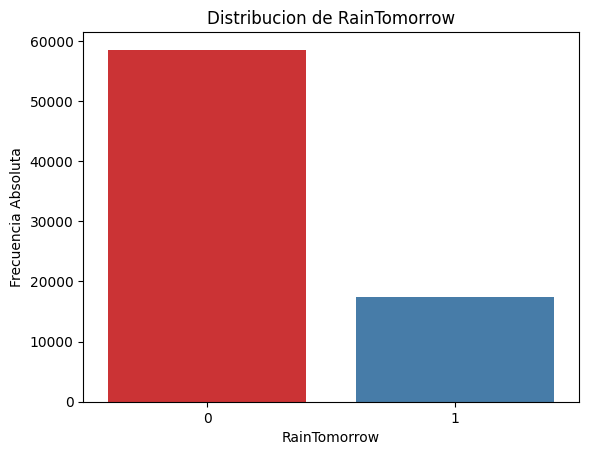

,proportion
RainTomorrow,
0,0.77047
1,0.22953


In [335]:
sns.countplot(data=df, x="RainTomorrow", palette="Set1")
plt.title("Distribucion de RainTomorrow")
plt.ylabel("Frecuencia Absoluta")
plt.show()

df.RainTomorrow.value_counts(normalize=True)

### Variables numericas

Las variables numericas incluyen:
* Temperatura: Minima, Maxima, a las 9am y a las 3pm
* Humedad: A las 9am y a las 3pm
* Nubosidad: A las 9am y a las 3pm
* Presion: A las 9am y a las 3pm
* Velocidad del viento: De la rafaga de viento, a las 9am a las 3pm
* Precipitacion, horas despejadas, evaporacion,

Se observa que la moyoria de variables se distribuyen de manera simetrica, aunque algunas como precipitacion o evaporacion estan sesgadas. Esto se tendra en cuenta a la hora de imputar nulos con la moda o la media.

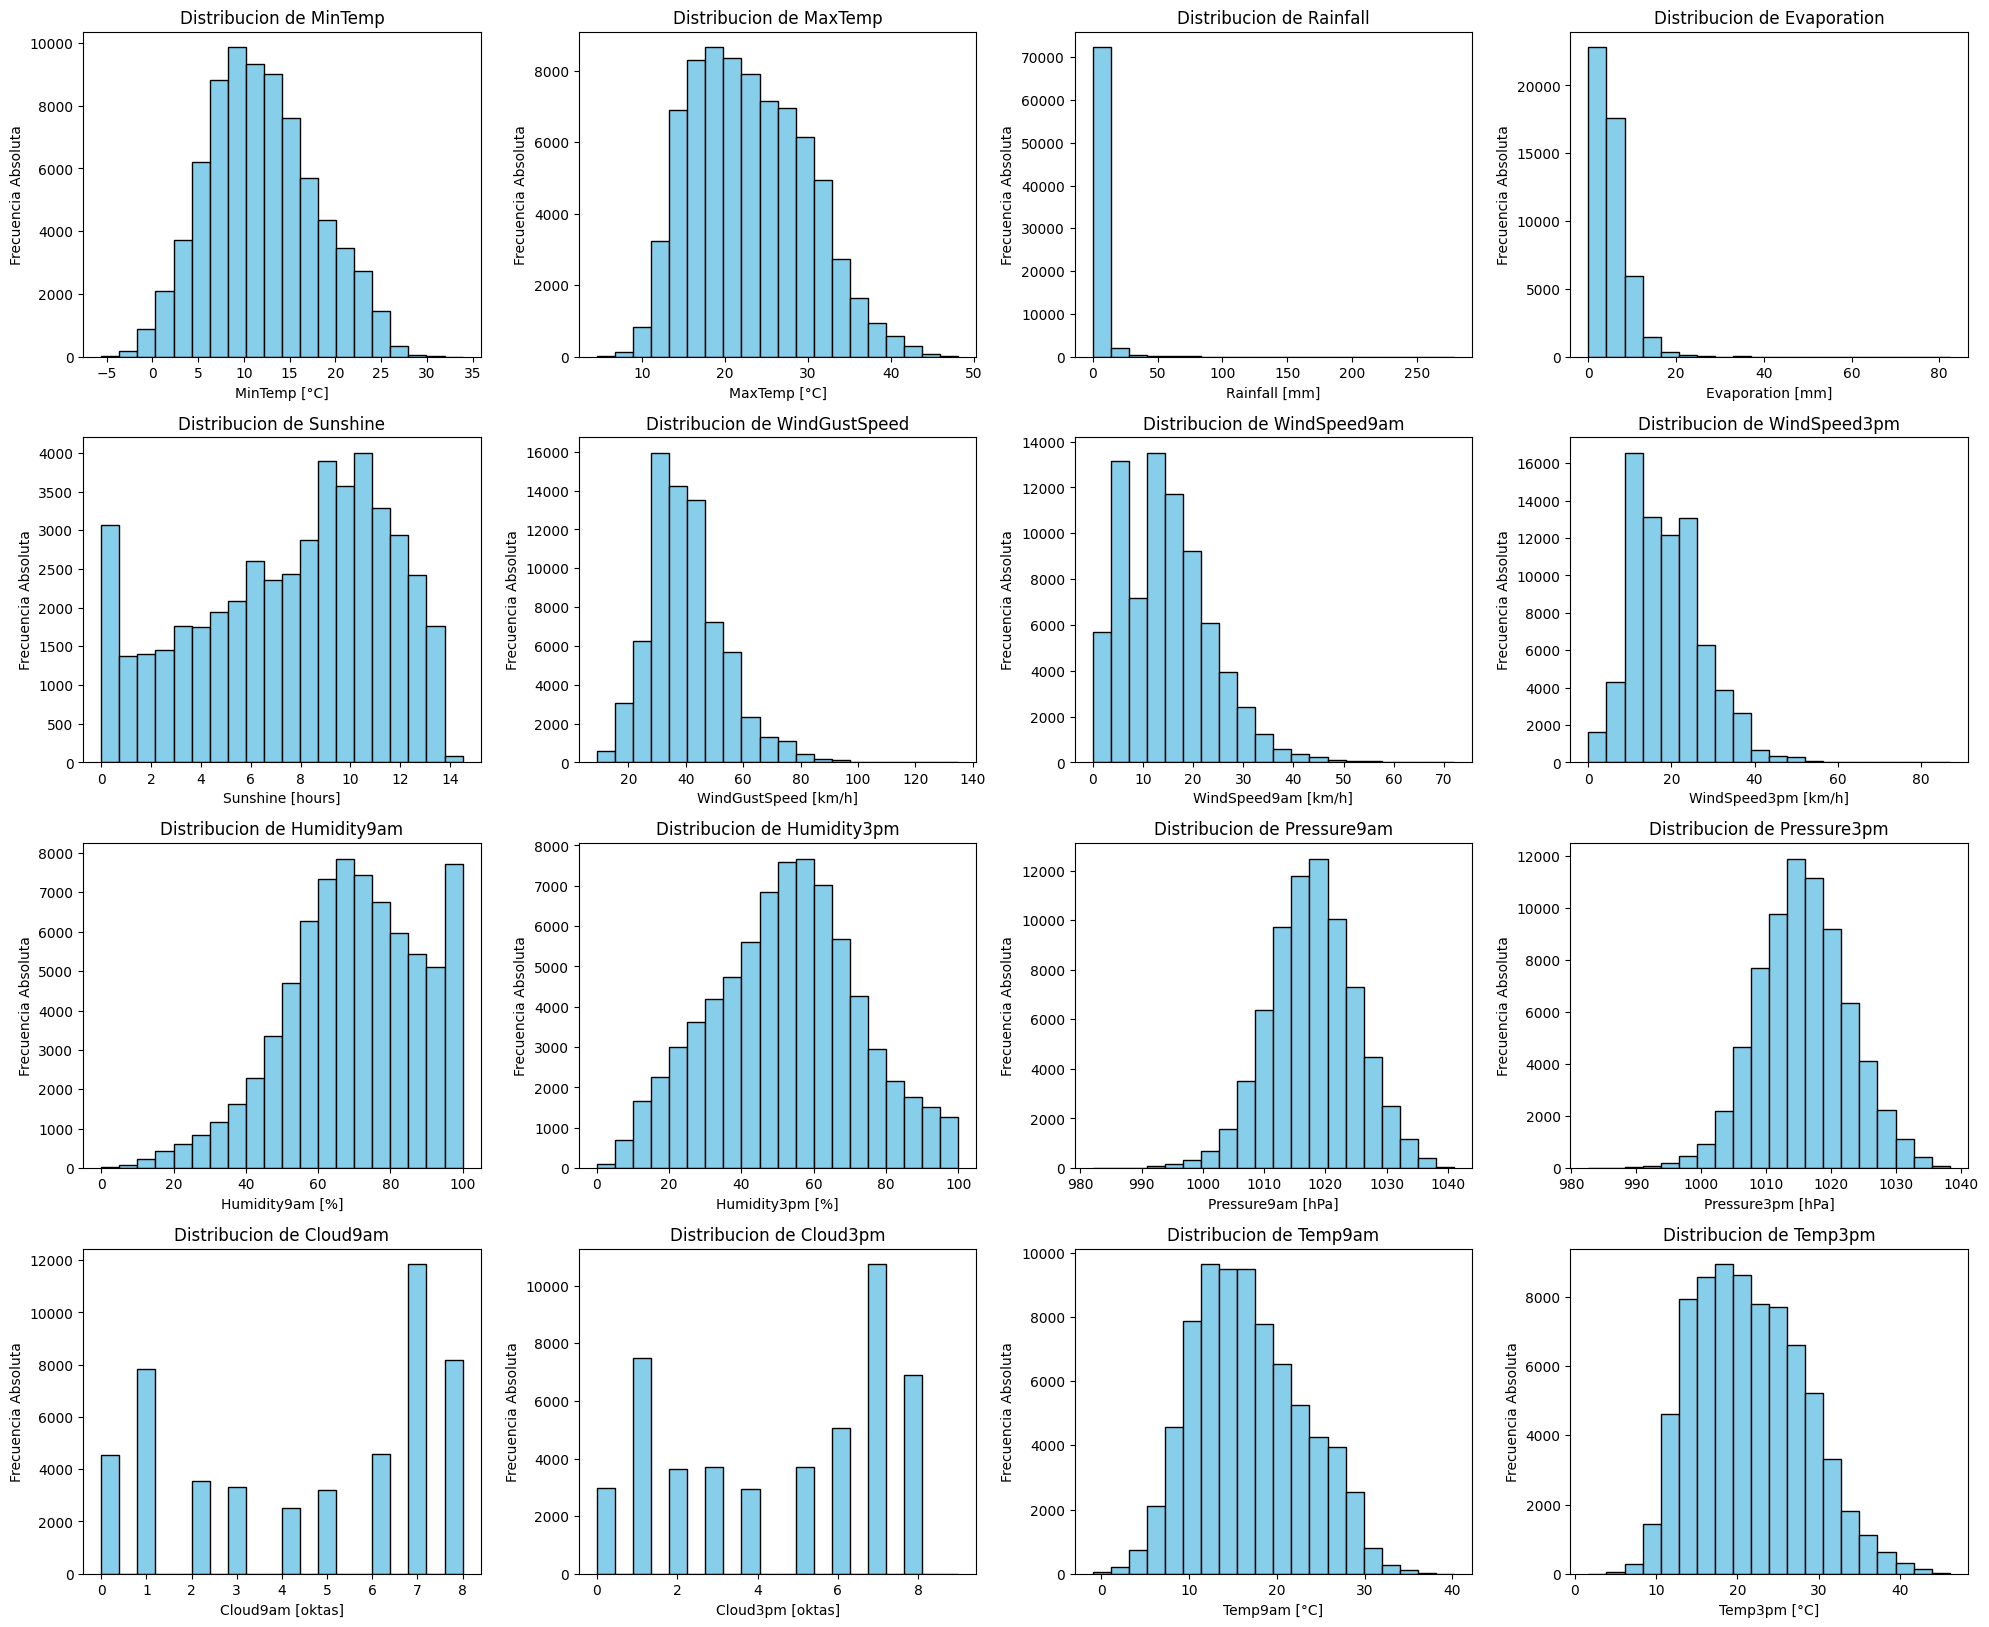

In [336]:
numeric_columns = df.select_dtypes(include=["float64"]).columns

plt.figure(figsize=(20, 20))

for i, column in enumerate(numeric_columns, 1):
    plt.subplot(5, 4, i)
    plt.hist(df[column].dropna(), bins=20, color='skyblue', edgecolor='black')
    plt.title(f'Distribucion de {column}')
    plt.xlabel(f"{column} [{units[column]}]")
    plt.ylabel('Frecuencia Absoluta')

plt.tight_layout()
plt.show()


Se observa nuevamenta que algunas variables como Rainfall tienen colas pesadas/estan sesgadas En el caso de rainfall tambien se observa una alta correlacion entre valores muy altos de esta variable y lluvia mañana

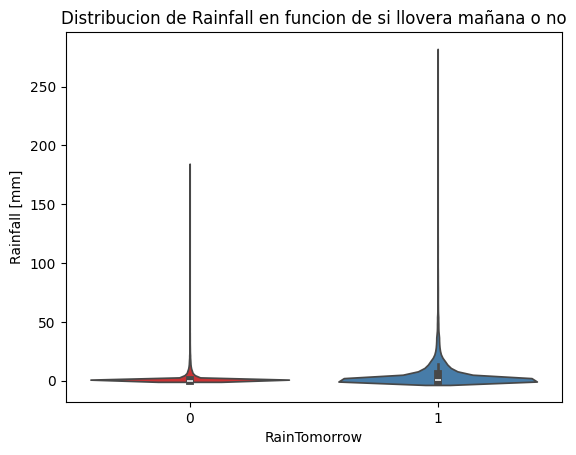

In [337]:
sns.violinplot(data=df, x="RainTomorrow", y="Rainfall", palette="Set1")
plt.title("Distribucion de Rainfall en funcion de si llovera mañana o no")
plt.ylabel("Rainfall [mm]")
plt.show()

### Variables categoricas

Las variables categoricas son:

* Locacion y Region
* Direccion del viente: De la rafaga de viento, a las 9am y a las 3pm

Parece existir alguna correlacion debil entre  algunos valores posibles de estas columnas y el valor de RainTomorrow

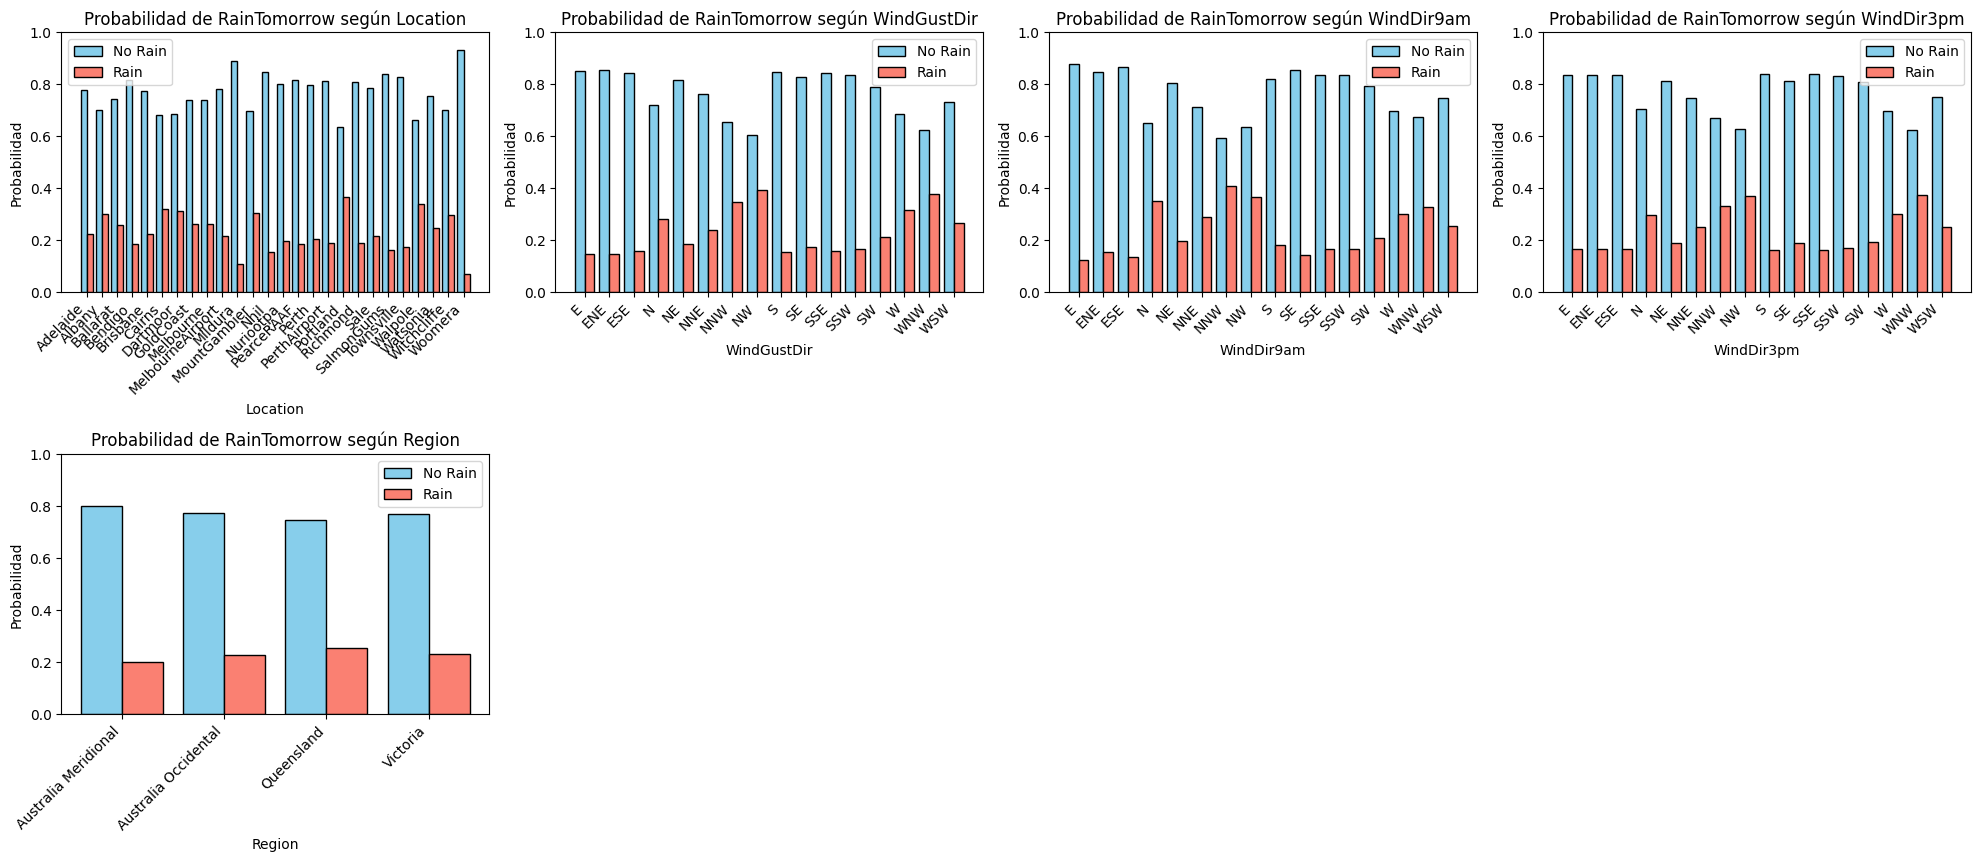

In [338]:
import matplotlib.pyplot as plt

categorical_columns = df.select_dtypes(include=["object"]).columns

plt.figure(figsize=(20, 20))

for i, column in enumerate(categorical_columns, 1):
    plt.subplot(5, 4, i)

    ct = pd.crosstab(df[column], df['RainTomorrow'])
    ct_norm = ct.div(ct.sum(axis=1), axis=0)

    width = 0.4
    x = np.arange(len(ct_norm))

    plt.bar(x - width/2, ct_norm[0], width=width, label='No Rain', color='skyblue', edgecolor='black')
    plt.bar(x + width/2, ct_norm[1], width=width, label='Rain', color='salmon', edgecolor='black')

    plt.title(f'Probabilidad de RainTomorrow según {column}')
    plt.xlabel(column)
    plt.ylabel('Probabilidad')
    plt.ylim(0, 1)
    plt.xticks(x, ct_norm.index, rotation=45, ha='right')
    plt.legend()

plt.tight_layout()
plt.show()


### Analisis de correlacion

Parece haber grupos de variables muy correlacionadas entre si:
* Temp3pm, Temp9am y MaxTemp: Se decidio eliminar las columnas Temp9am y MaxTemp y dejar Temp3pm.
* Pressure9am y Pressure3pm: Se decidio eliminar la columna Pressure9am

Tambien es interesante notar que hay variables con muy poca correlacion entre si pero correlacionadas con el target (Sunshine y evaporacion; Rainfall y cloud).

Por ultimo se ve que hay variables mas relacionadas con el target que otras

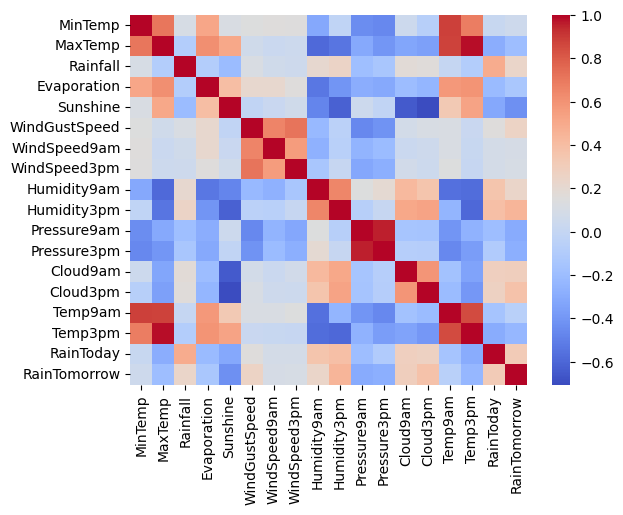

In [339]:
sns.heatmap(df.corr(numeric_only=True), cmap='coolwarm', annot=False)
plt.show()

Analizando mas en detalle Sunshine y Pressure9am, se que la cantidad de Raintomorrow = 1 aumenta considerablemente para valores bajos de primero y altos del segundo.

En base a esto se considero crear una mas tarde una nueva feature con el ratio
Pressure:Sunshine

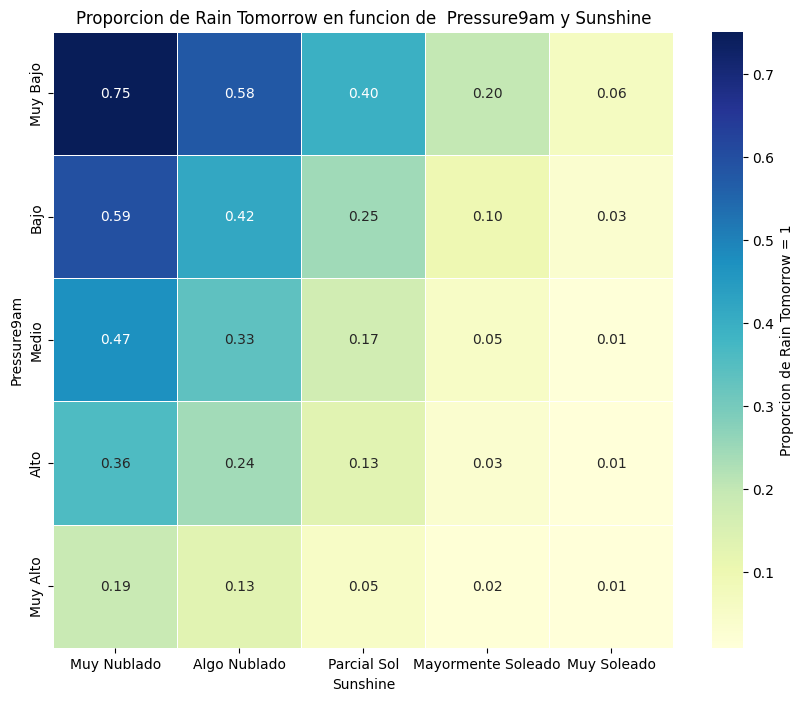

In [340]:
df_for_pivot = pd.DataFrame({
    'Pressure9am': df['Pressure9am'],
    'Sunshine': df['Sunshine'],
    'RainTomorrow': df['RainTomorrow']
})

df_for_pivot.dropna(inplace=True)

df_for_pivot["RainTomorrow"] = df_for_pivot["RainTomorrow"].astype("int64")

df_for_pivot['Pressure9am_binned'] = pd.qcut(
    df_for_pivot['Pressure9am'],
    q=5,
    labels=["Muy Bajo", "Bajo", "Medio", "Alto", "Muy Alto"]
)

df_for_pivot['Sunshine_binned'] = pd.qcut(
    df_for_pivot['Sunshine'],
    q=5,
    labels=["Muy Nublado", "Algo Nublado", "Parcial Sol", "Mayormente Soleado", "Muy Soleado"]
)


heatmap_data = df_for_pivot.pivot_table(values='RainTomorrow',
                                       index='Pressure9am_binned',
                                       columns='Sunshine_binned',
                                       aggfunc='mean')

plt.figure(figsize=(10, 8))
sns.heatmap(heatmap_data, annot=True, cmap="YlGnBu", cbar_kws={'label': 'Proporcion de Rain Tomorrow = 1'},
            fmt='.2f', linewidths=0.5)
plt.title("Proporcion de Rain Tomorrow en funcion de  Pressure9am y Sunshine")
plt.xlabel('Sunshine')
plt.ylabel('Pressure9am')
plt.show()


Algo parecido se ve para valores altos de Rainfall y Clod3pm, por lo que se considero crear una variable con el producto de ambas

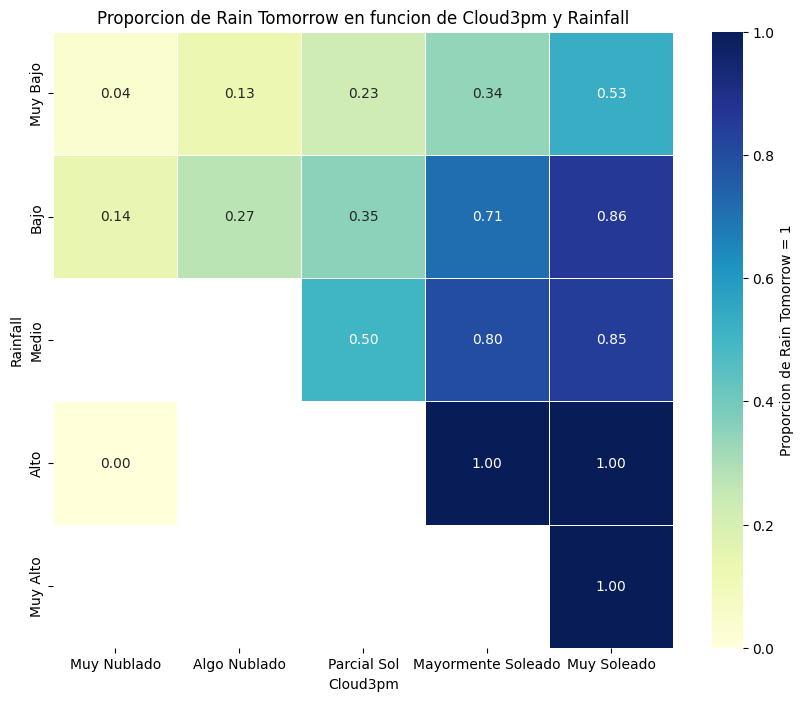

In [341]:
pressure_bins = 5

df_for_pivot = pd.DataFrame({
    'Rainfall': df['Rainfall'],
    'Cloud3pm': df['Cloud3pm'],
    'RainTomorrow': df['RainTomorrow']
})

df_for_pivot.dropna(inplace=True)

df_for_pivot["RainTomorrow"] = df_for_pivot["RainTomorrow"].astype("int64")

df_for_pivot['Rainfall'] = pd.cut(
    df_for_pivot['Rainfall'],
    bins=pressure_bins,
    labels=["Muy Bajo", "Bajo", "Medio", "Alto", "Muy Alto"]
)

df_for_pivot['Cloud3pm'] = pd.qcut(
    df_for_pivot['Cloud3pm'],
    q=5,
    labels=["Muy Nublado", "Algo Nublado", "Parcial Sol", "Mayormente Soleado", "Muy Soleado"]
)


heatmap_data = df_for_pivot.pivot_table(values='RainTomorrow',
                                       index='Rainfall',
                                       columns='Cloud3pm',
                                       aggfunc='mean')

plt.figure(figsize=(10, 8))
sns.heatmap(heatmap_data, annot=True, cmap="YlGnBu", cbar_kws={'label': 'Proporcion de Rain Tomorrow = 1'},
            fmt='.2f', linewidths=0.5)
plt.title("Proporcion de Rain Tomorrow en funcion de Cloud3pm y Rainfall")
plt.xlabel('Cloud3pm')
plt.ylabel('Rainfall')
plt.show()


### Analisis de nulos

Por ultimo se observa que existen varias columnas con valores nulos

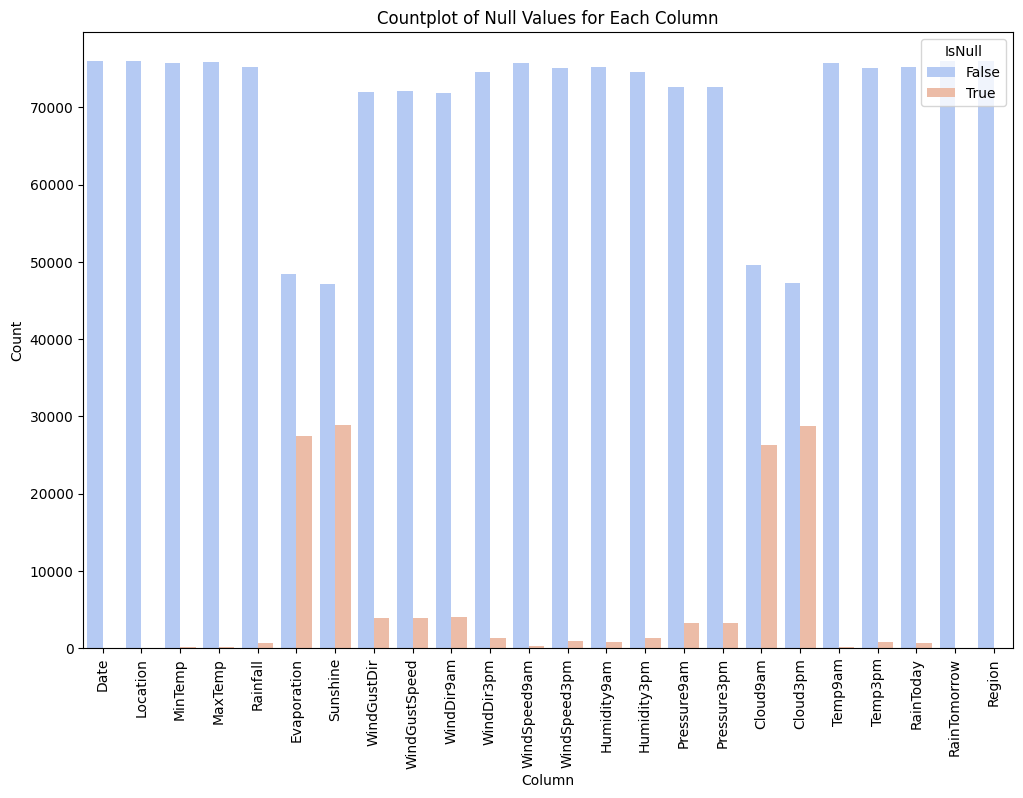

In [342]:
import seaborn as sns
import matplotlib.pyplot as plt

# Create a DataFrame with True/False indicating if the value is null
null_df = df.isnull()

# Melt the DataFrame so it is in long-form format for countplot
null_df_melted = null_df.melt(var_name='Column', value_name='IsNull')

# Plot the count of null values for each column
plt.figure(figsize=(12, 8))
sns.countplot(data=null_df_melted, x='Column', hue='IsNull', palette='coolwarm')

# Rotate the x-axis labels for better visibility
plt.xticks(rotation=90)

# Add titles and labels
plt.title('Countplot of Null Values for Each Column')
plt.xlabel('Column')
plt.ylabel('Count')

plt.show()


In [343]:
df.isna().sum() * 100 / df.shape[0]

,0
Date,0.000000
Location,0.000000
MinTemp,0.227778
MaxTemp,0.122447
Rainfall,0.879514
Evaporation,36.198338
Sunshine,38.010033
WindGustDir,5.130940
WindGustSpeed,5.063791
WindDir9am,5.370568


## Eliminacion de filas nulas y features

In [344]:
df_filtered = df.copy()

Reviso que no haya valores raros o filas duplicadas:

In [345]:
has_null_char = df_filtered.astype("str").eq("NULL").any()
print("Columns with null chars:")
print(has_null_char[has_null_char == True])
print()
print("Columns with negative values:")
print((df_filtered.select_dtypes('number') < 0).any())
print()
print("Duplicated columns:")
print(df_filtered.duplicated(subset=["Date", "Location"]).value_counts())


Columns with null chars:
Series([], dtype: bool)

Columns with negative values:
MinTemp           True
MaxTemp          False
Rainfall         False
Evaporation      False
Sunshine         False
WindGustSpeed    False
WindSpeed9am     False
WindSpeed3pm     False
Humidity9am      False
Humidity3pm      False
Pressure9am      False
Pressure3pm      False
Cloud9am         False
Cloud3pm         False
Temp9am           True
Temp3pm          False
RainToday        False
RainTomorrow     False
dtype: boolean

Duplicated columns:
False    75951
Name: count, dtype: int64


In [346]:
df_filtered.isna().sum() * 100 / df_filtered.shape[0]

,0
Date,0.000000
Location,0.000000
MinTemp,0.227778
MaxTemp,0.122447
Rainfall,0.879514
Evaporation,36.198338
Sunshine,38.010033
WindGustDir,5.130940
WindGustSpeed,5.063791
WindDir9am,5.370568


Se eligio 0.4 como punto de corte a partir del cual una columna con esa proporcion de valores nulos deberia ser eliminada. Como ningua columna supera este valor, se mantendran todas.

Por otro lado, se eligio a 0.02 como el valor a partir del cual una columna con esa cantidad de nulos no comprometeria demasiadas filas, por lo que se decidio que borrar esos registros no implicaria perder demasiada informacion. Por lo tanto se decidio eliminar esas filas para ahorrar la imputacion de nulos

In [347]:
na_percentaje = df_filtered.isna().sum() * 100 / df_filtered.shape[0]
columns = na_percentaje[na_percentaje < 2].index.tolist()
filter_mask = df_filtered[columns].isna().any(axis=1)
df_filtered = df_filtered[~filter_mask]

na_percentaje = df_filtered.isna().sum() * 100 / df_filtered.shape[0]
columns = na_percentaje[na_percentaje < 2].index.tolist()
filter_mask = df_filtered[columns].isna().any(axis=1)
df_filtered = df_filtered[~filter_mask]

In [348]:
df_filtered.reset_index(drop=True, inplace=True)

In [349]:
df_filtered.isna().sum() * 100 / df_filtered.shape[0]

,0
Date,0.000000
Location,0.000000
MinTemp,0.000000
MaxTemp,0.000000
Rainfall,0.000000
Evaporation,35.731861
Sunshine,37.456941
WindGustDir,3.827437
WindGustSpeed,3.821969
WindDir9am,4.776095


### Eliminacion de Locacion y Region:

En funcion del analisis visual previo, de evaluar la desviacion estandar de probabilidades de RainTomorrow en funcion de esas coluumnas y ver la feature importance de modelos rapidos de DecisionTree, se determino que las features Locacion y Region no aportan informacion util a la hora de determinar el target, por lo que se decidio eliminarlas


In [350]:
location_probs = df_filtered[["Location", "RainTomorrow"]].groupby('Location').value_counts(normalize=True).reset_index(name='Probability')
display(location_probs.groupby('RainTomorrow')['Probability'].std().reset_index(name='Standard Deviation'))

location_probs = df_filtered[["Region", "RainTomorrow"]].groupby('Region').value_counts(normalize=True).reset_index(name='Probability')
display(location_probs.groupby('RainTomorrow')['Probability'].std().reset_index(name='Standard Deviation'))

,RainTomorrow,Standard Deviation
0,0,0.070991
1,1,0.070991


,RainTomorrow,Standard Deviation
0,0,0.022149
1,1,0.022149


In [351]:
df_filtered.drop(columns=["Location", "Region"], inplace=True)


En funcion del analisis previo de la matriz de correlaciones se elimina las features Pressure9am, MaxTemp y Temp9am

In [352]:
df_dropped = df_filtered[["Pressure9am", "Date"]] # Me la guardo para feature engineering

df_filtered.drop(columns=["Temp9am", "MaxTemp", "Pressure9am"], inplace=True)

In [353]:
df_filtered.to_parquet('weatherAUS_selectedregions_cleaned.parquet')
df_dropped.to_parquet('weatherAUS_selectedregions_dropped.parquet')

del df_filtered
del df_dropped

## Division en test y train

Antes de imputar nulos y codificar columnas, separo en train y test. Se guarda el 80% del dataset para train. Como hay una variable temporal involucrada, se decide separar el dataset por fecha

In [354]:
df = pd.read_parquet('weatherAUS_selectedregions_cleaned.parquet')
df_dropped = pd.read_parquet('weatherAUS_selectedregions_dropped.parquet')

In [355]:
train_size = int(len(df) * 0.8)
df = df.sort_values(by='Date')
df_dropped = df_dropped.sort_values(by='Date')

train_df = df[:train_size]
test_df = df[train_size:]

df_dropped_train = df_dropped[:train_size]
df_dropped_test = df_dropped[train_size:]

print("Train size:", len(train_df))
print("Test size:", len(test_df))


Train size: 58524
Test size: 14632


Por suerte la proporcion del target es similar en ambos sets

In [356]:
display(train_df['RainTomorrow'].value_counts(normalize=True))
display(test_df['RainTomorrow'].value_counts(normalize=True))

,proportion
RainTomorrow,
0,0.773785
1,0.226215


,proportion
RainTomorrow,
0,0.779661
1,0.220339


In [357]:
train_df.to_parquet('weatherAUS_selectedregions_train.parquet')
test_df.to_parquet('weatherAUS_selectedregions_test.parquet')

df_dropped_train.to_parquet('weatherAUS_selectedregions_dropped_train.parquet')
df_dropped_test.to_parquet('weatherAUS_selectedregions_dropped_test.parquet')

del train_df
del test_df
del df_dropped_train
del df_dropped_test

## Codificacion e imputacion


In [358]:
df_train_encoded = pd.read_parquet('weatherAUS_selectedregions_train.parquet')
df_test_encoded = pd.read_parquet('weatherAUS_selectedregions_test.parquet')

df_dropped_train = pd.read_parquet('weatherAUS_selectedregions_dropped_train.parquet')
df_dropped_test = pd.read_parquet('weatherAUS_selectedregions_dropped_test.parquet')

### Codificacion e imputacion de categoricas

#### Direccion del viento

Inputo nulos para las columnas de direccion del viento usando la moda. Se considero usar el valor en un momento del dia para la imputacion del valor en el otro para registros donde uno de los dos estaba presente, pero se vio que los valores suelen cambiar.

Se tuvo cuidado de no leckear data del set train al set test.

In [359]:
(df_train_encoded["WindDir3pm"] == df_train_encoded["WindDir9am"]).value_counts()

,count
False,48091
True,10433


In [360]:
windgustdir_mode = df_train_encoded['WindGustDir'].mode()[0]
winddir3pm_mode = df_train_encoded['WindDir3pm'].mode()[0]
winddir9am_mode = df_train_encoded['WindDir9am'].mode()[0]

for df in [df_train_encoded, df_test_encoded]:
    df['WindGustDir'].fillna(windgustdir_mode, inplace=True)
    df['WindDir3pm'].fillna(winddir3pm_mode, inplace=True)
    df['WindDir9am'].fillna(winddir9am_mode, inplace=True)


Codifico las variables de direccion del viento y region con OHE


In [361]:
df_train_encoded = pd.get_dummies(
    df_train_encoded, columns=["WindGustDir", "WindDir9am", "WindDir3pm"], drop_first=True
)

df_test_encoded = pd.get_dummies(
    df_test_encoded, columns=["WindGustDir", "WindDir9am", "WindDir3pm"], drop_first=True
)

df_test_encoded = df_test_encoded.reindex(columns=df_train_encoded.columns, fill_value=0)

In [362]:
df_test_encoded

,Date,MinTemp,Rainfall,Evaporation,Sunshine,WindGustSpeed,WindSpeed9am,WindSpeed3pm,Humidity9am,Humidity3pm,Pressure3pm,Cloud9am,Cloud3pm,Temp3pm,RainToday,RainTomorrow,WindGustDir_ENE,WindGustDir_ESE,WindGustDir_N,WindGustDir_NE,WindGustDir_NNE,WindGustDir_NNW,WindGustDir_NW,WindGustDir_S,WindGustDir_SE,WindGustDir_SSE,WindGustDir_SSW,WindGustDir_SW,WindGustDir_W,WindGustDir_WNW,WindGustDir_WSW,WindDir9am_ENE,WindDir9am_ESE,WindDir9am_N,WindDir9am_NE,WindDir9am_NNE,WindDir9am_NNW,WindDir9am_NW,WindDir9am_S,WindDir9am_SE,WindDir9am_SSE,WindDir9am_SSW,WindDir9am_SW,WindDir9am_W,WindDir9am_WNW,WindDir9am_WSW,WindDir3pm_ENE,WindDir3pm_ESE,WindDir3pm_N,WindDir3pm_NE,WindDir3pm_NNE,WindDir3pm_NNW,WindDir3pm_NW,WindDir3pm_S,WindDir3pm_SE,WindDir3pm_SSE,WindDir3pm_SSW,WindDir3pm_SW,WindDir3pm_W,WindDir3pm_WNW,WindDir3pm_WSW
11091,2015-10-23,10.0,1.0,NaN,NaN,30.0,13.0,15.0,90.0,68.0,1022.1,8.0,8.0,15.0,0,0,False,False,False,False,False,False,False,False,False,False,True,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,True,False,False,False,False,False,False,False,False,False,False,False,True,False,False,False,False,False
35614,2015-10-23,17.5,0.0,5.6,11.1,31.0,13.0,19.0,61.0,71.0,1012.7,1.0,2.0,26.6,0,0,False,False,False,False,True,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,True,False,False,False,False,False,False,False,False,True,False,False,False,False,False,False,False,False,False,False,False,False
26775,2015-10-23,10.6,0.0,2.0,4.1,46.0,9.0,15.0,66.0,54.0,1021.8,7.0,7.0,16.1,0,0,False,False,False,False,False,False,False,True,False,False,False,False,False,False,False,False,False,False,False,False,False,False,True,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,True,False,False,False
66948,2015-10-23,16.7,0.0,5.0,6.6,37.0,17.0,17.0,68.0,63.0,1016.2,7.0,7.0,21.0,0,0,False,False,False,False,False,False,False,False,False,False,False,True,False,False,False,False,False,False,False,False,False,False,False,False,False,False,True,False,False,False,False,False,False,False,False,False,False,False,False,False,False,True,False,False,False
69849,2015-10-23,12.9,0.0,NaN,NaN,37.0,17.0,19.0,48.0,17.0,NaN,NaN,NaN,30.2,0,0,False,False,False,False,False,False,True,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,True,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,True,False
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
19942,2017-06-25,5.6,0.0,NaN,NaN,31.0,0.0,15.0,87.0,45.0,1018.4,0.0,4.0,17.8,0,0,False,False,False,False,False,False,False,False,False,False,False,True,False,False,False,False,False,True,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,True,False,False,False
58784,2017-06-25,8.5,0.0,NaN,NaN,20.0,0.0,13.0,99.0,72.0,1027.5,NaN,NaN,14.6,0,0,False,False,False,False,False,False,False,False,False,True,False,False,False,False,False,False,False,True,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,True,False,False,False,False,False
67559,2017-06-25,6.3,0.0,1.6,7.9,26.0,4.0,11.0,75.0,49.0,1026.0,1.0,3.0,15.6,0,0,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,True,False,False,False,False,False,False,False,False,False,False,False,False,False,False,True,False,False,False,False,False,False
16951,2017-06-25,8.6,0.0,2.8,3.8,35.0,13.0,17.0,67.0,56.0,1015.0,7.0,7.0,13.4,0,1,False,False,False,False,False,False,True,False,Fa

### Inputacion de variables numericas


In [363]:
df_train_encoded.isna().sum().sort_values(ascending=False).head(7)

,0
Cloud3pm,19710
Sunshine,18975
Cloud9am,18874
Evaporation,18467
WindGustSpeed,2621
Pressure3pm,2495
MinTemp,0


In [364]:
correlations = df_train_encoded.corr(numeric_only=True)

correlations = correlations.apply(lambda x: abs(x))

#### Velocidad de rafaga de viento

Se observa una alta correlacion entre este feature y la velocidad del viento a distintos momentos del dia,

Se decida imputar esta feature interpolandola a partir de los otros dos valores

In [365]:
correlations["WindGustSpeed"].sort_values(ascending=False)

,WindGustSpeed
WindGustSpeed,1.000000
WindSpeed3pm,0.712651
WindSpeed9am,0.658310
Pressure3pm,0.407018
RainTomorrow,0.257151
Humidity9am,0.220309
Evaporation,0.209414
RainToday,0.153748
MinTemp,0.147400
WindGustDir_NE,0.126427


In [366]:
train_data = df_train_encoded[["WindGustSpeed", "WindSpeed9am", "WindSpeed3pm"]].dropna()
missing_data = df_train_encoded[df_train_encoded["WindGustSpeed"].isna()][["WindGustSpeed", "WindSpeed9am", "WindSpeed3pm"]]

model = LinearRegression()
model.fit(train_data[["WindSpeed9am", "WindSpeed3pm"]], train_data["WindGustSpeed"])

predicted_values = model.predict(missing_data[["WindSpeed9am", "WindSpeed3pm"]])
df_train_encoded.loc[df_train_encoded["WindGustSpeed"].isna(), "WindGustSpeed"] = predicted_values

missing_data = df_test_encoded[df_test_encoded["WindGustSpeed"].isna()][["WindGustSpeed", "WindSpeed9am", "WindSpeed3pm"]]
predicted_values = model.predict(missing_data[["WindSpeed9am", "WindSpeed3pm"]])
df_test_encoded.loc[df_test_encoded["WindGustSpeed"].isna(), "WindGustSpeed"] = predicted_values


#### Presion3pm

No hay correlacion con las otras variables (excepto Presusre9pm, pero de todos modos tenia la misma cantidad de nulos que esta)

Se deciide usar la media en base a que la distribucion es bastante simetrica
Se hace lo mismo com Pressure9am (Se quito del dataset pero se usara para crear features)

In [367]:
correlations["Pressure3pm"].sort_values(ascending=False)


,Pressure3pm
Pressure3pm,1.000000
MinTemp,0.466415
WindGustSpeed,0.407018
Temp3pm,0.371216
Evaporation,0.299307
RainTomorrow,0.281290
WindSpeed3pm,0.275882
WindSpeed9am,0.203990
Humidity9am,0.191148
Rainfall,0.147166


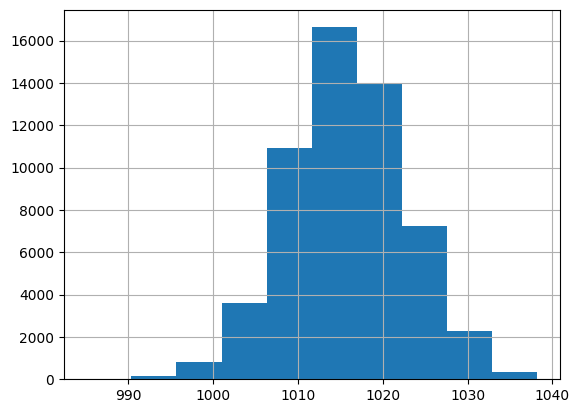

In [368]:
df_train_encoded["Pressure3pm"].hist()

mean_pressure3pm = df_train_encoded["Pressure3pm"].mean()
mean_pressure9am = df_dropped_train["Pressure9am"].mean()

df_train_encoded.loc[:, "Pressure3pm"] = df_train_encoded["Pressure3pm"].fillna(mean_pressure3pm)
df_dropped_train.loc[:, "Pressure9am"] = df_dropped_train["Pressure9am"].fillna(mean_pressure9am)

df_test_encoded.loc[:, "Pressure3pm"] = df_test_encoded["Pressure3pm"].fillna(mean_pressure3pm)
df_dropped_test.loc[:, "Pressure9am"] = df_dropped_test["Pressure9am"].fillna(mean_pressure9am)

#### Cloud9am y Cloud3pm

Tienen buena correlacion con Sunshine, pero Sunshine tiene bastantes nulos, por lo que directamente se va a usar la media para la imputacion

,Cloud9am
Cloud9am,1.000000
Sunshine,0.652153
Cloud3pm,0.594548
Humidity3pm,0.511641
Humidity9am,0.423097
Temp3pm,0.347086
RainTomorrow,0.300447
RainToday,0.287713
Evaporation,0.216170
Rainfall,0.179988


,Cloud3pm
Cloud3pm,1.000000
Sunshine,0.705250
Cloud9am,0.594548
Humidity3pm,0.531490
Temp3pm,0.395053
RainTomorrow,0.372645
Humidity9am,0.358156
RainToday,0.278033
Evaporation,0.246567
Rainfall,0.166696


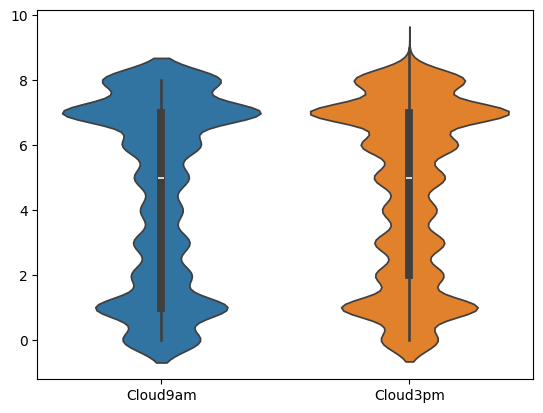

In [369]:
sns.violinplot(df_train_encoded[["Cloud9am", "Cloud3pm"]])

display(correlations["Cloud9am"].sort_values(ascending=False))
display(correlations["Cloud3pm"].sort_values(ascending=False))

In [370]:
cloud9am_mean = df_train_encoded["Cloud9am"].mean()
cloud3pm_mean = df_train_encoded["Cloud3pm"].mean()

df_train_encoded.loc[:, "Cloud9am"] = df_train_encoded["Cloud9am"].fillna(cloud9am_mean)
df_train_encoded.loc[:, "Cloud3pm"] = df_train_encoded["Cloud3pm"].fillna(cloud3pm_mean)

df_test_encoded.loc[:, "Cloud9am"] = df_test_encoded["Cloud9am"].fillna(cloud9am_mean)
df_test_encoded.loc[:, "Cloud3pm"] = df_test_encoded["Cloud3pm"].fillna(cloud3pm_mean)


#### Sunshine

Se aprovecha la correlacion con Cloud3pm, Cloud9am y Humidity3pm para calcular sunshine a partir de interpolarlos

Hay que notar que Cloud3pm y CLoud9am tambien fueron inputados usando su propia media.

In [371]:
correlations["Sunshine"].sort_values(ascending=False)


,Sunshine
Sunshine,1.000000
Cloud3pm,0.705250
Cloud9am,0.652153
Humidity3pm,0.622805
Temp3pm,0.524418
Humidity9am,0.477350
RainTomorrow,0.432189
Evaporation,0.396502
RainToday,0.321883
Rainfall,0.209953


In [372]:

train_data = df_train_encoded[["Sunshine", "Cloud3pm", "Cloud9am", "Humidity3pm"]].dropna()
missing_data = df_train_encoded[df_train_encoded["Sunshine"].isna()][["Cloud3pm", "Cloud9am", "Humidity3pm"]]

model = LinearRegression()
model.fit(train_data[["Cloud3pm", "Cloud9am", "Humidity3pm"]], train_data["Sunshine"])

predicted_values = model.predict(missing_data[["Cloud3pm", "Cloud9am", "Humidity3pm"]])
df_train_encoded.loc[df_train_encoded["Sunshine"].isna(), "Sunshine"] = predicted_values

missing_data = df_test_encoded[df_test_encoded["Sunshine"].isna()][["Cloud3pm", "Cloud9am", "Humidity3pm"]]
predicted_values = model.predict(missing_data[["Cloud3pm", "Cloud9am", "Humidity3pm"]])
df_test_encoded.loc[df_test_encoded["Sunshine"].isna(), "Sunshine"] = predicted_values


#### Evaporation

Se decide imputar usando la mediana debido a que la distribucion esta altamante sesgada

,Evaporation
Evaporation,1.000000
Temp3pm,0.597601
Humidity9am,0.540704
MinTemp,0.515873
Humidity3pm,0.417470
Sunshine,0.396502
Pressure3pm,0.299307
Cloud3pm,0.246567
RainToday,0.219581
Cloud9am,0.216170


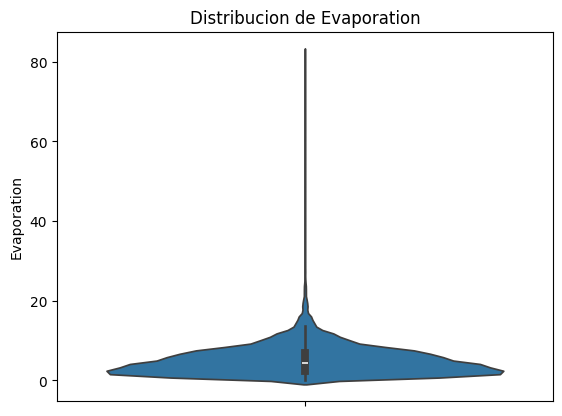

In [373]:
display(correlations["Evaporation"].sort_values(ascending=False))
sns.violinplot(df_train_encoded["Evaporation"])
plt.title("Distribucion de Evaporation")
plt.show()

In [374]:
df_train_encoded.loc[:, "Evaporation"] = df_train_encoded["Evaporation"].fillna(df_train_encoded["Evaporation"].median())
df_test_encoded.loc[:, "Evaporation"] = df_test_encoded["Evaporation"].fillna(df_train_encoded["Evaporation"].median())


In [375]:
df_train_encoded.isna().sum().sort_values(ascending=False)

,0
Date,0
MinTemp,0
Rainfall,0
Evaporation,0
Sunshine,0
...,...
WindDir3pm_SSW,0
WindDir3pm_SW,0
WindDir3pm_W,0
WindDir3pm_WNW,0


In [376]:
df_train_encoded.to_parquet('weatherAUS_selectedregions_train_encoded.parquet')
df_test_encoded.to_parquet('weatherAUS_selectedregions_test_encoded.parquet')

df_dropped_train.to_parquet('weatherAUS_selectedregions_dropped_train_encoded.parquet')
df_dropped_test.to_parquet('weatherAUS_selectedregions_dropped_test_encoded.parquet')

## Outliers

Se realiza el analisis de outliers en base al z-score. Se observa una alta presencia de outliers a lo largo de varias variables del dataset.

Aun asi, se decide no quitar ninguno, ya que algunos valores extremos (por ejemplo de rainfall) son fundamentales para predecir el target y no hay razones para pensar que se originan por errores de medicion. Ademas se considera que los modelos utilizados son robustos a la presencia de estos.

In [377]:
df_train = pd.read_parquet('weatherAUS_selectedregions_train_encoded.parquet')
df_test = pd.read_parquet('weatherAUS_selectedregions_test_encoded.parquet')

In [378]:
def z_calculation(serie):
  media = np.mean(serie)
  std = np.std(serie)
  return (serie - media) / std

In [379]:
df_train.describe()

,Date,MinTemp,Rainfall,Evaporation,Sunshine,WindGustSpeed,WindSpeed9am,WindSpeed3pm,Humidity9am,Humidity3pm,Pressure3pm,Cloud9am,Cloud3pm,Temp3pm,RainToday,RainTomorrow
count,58524,58524.000000,58524.000000,58524.000000,58524.000000,58524.000000,58524.000000,58524.000000,58524.000000,58524.000000,58524.000000,58524.000000,58524.000000,58524.000000,58524.0,58524.0
mean,2012-05-09 13:03:46.614721792,11.799645,2.137673,4.894221,7.443031,40.259638,14.722541,19.443630,69.328361,51.840168,1015.762334,4.486431,4.540243,21.343463,0.2283,0.226215
min,2008-07-01 00:00:00,-5.600000,0.000000,0.000000,0.000000,9.000000,0.000000,2.000000,0.000000,0.000000,985.100000,0.000000,0.000000,3.200000,0.0,0.0
25%,2010-07-26 00:00:00,7.500000,0.000000,3.200000,5.453706,31.000000,9.000000,13.000000,57.000000,38.000000,1011.300000,3.000000,3.000000,16.100000,0.0,0.0
50%,2012-04-30 00:00:00,11.400000,0.000000,4.400000,7.696326,39.000000,13.000000,19.000000,70.000000,52.000000,1015.762334,4.486431,4.540243,20.800000,0.0,0.0
75%,2014-02-24 00:00:00,15.800000,0.800000,5.700000,9.900000,48.000000,20.000000,24.000000,84.000000,65.000000,1020.200000,7.000000,6.000000,26.100000,0.0,0.0
max,2015-10-23 00:00:00,33.900000,278.400000,82.400000,14.686676,124.000000,72.000000,87.000000,100.000000,100.000000,1038.200000,8.000000,9.000000,46.100000,1.0,1.0
std,NaN,5.915659,7.813557,3.339865,3.325436,13.173346,8.929487,8.626175,18.872160,20.102185,6.806013,2.336378,2.192879,6.640633,0.41974,0.418383


In [380]:
z_scores = df_train.loc[:, df_train.select_dtypes("float64").columns].apply(z_calculation)
z_scores_abs = z_scores.apply(lambda x: abs(x))

outliers_mask = z_scores_abs > 3

outliers_df = df_train[outliers_mask.any(axis=1)]

outliers_mask.apply(lambda x: x.value_counts())


,MinTemp,Rainfall,Evaporation,Sunshine,WindGustSpeed,WindSpeed9am,WindSpeed3pm,Humidity9am,Humidity3pm,Pressure3pm,Cloud9am,Cloud3pm,Temp3pm
False,58515,57647,57771,58524.0,57867,57976,58114,58336,58524.0,58334,58524.0,58524.0,58361
True,9,877,753,NaN,657,548,410,188,NaN,190,NaN,NaN,163


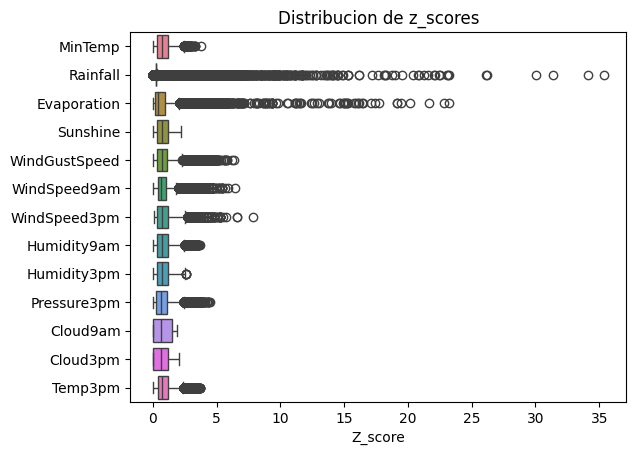

In [381]:
sns.boxplot(data=z_scores_abs, orient="y")
plt.title("Distribucion de z_scores")
plt.xlabel("Z_score")
plt.show()

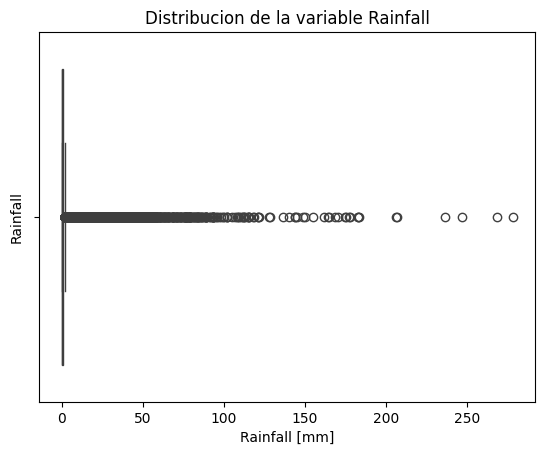

In [382]:
sns.boxplot(data=df_train["Rainfall"], orient="y")
plt.ylabel("Rainfall")
plt.xlabel("Rainfall [mm]")
plt.title("Distribucion de la variable Rainfall")
plt.show()

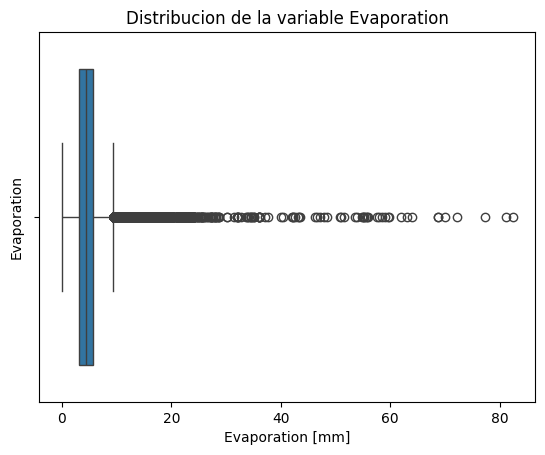

In [383]:
sns.boxplot(data=df_train["Evaporation"], orient="y")
plt.ylabel("Evaporation")
plt.xlabel("Evaporation [mm]")
plt.title(f"Distribucion de la variable Evaporation")
plt.show()

## Feature engineering

In [384]:
df_train = pd.read_parquet('weatherAUS_selectedregions_train_encoded.parquet')
df_test = pd.read_parquet('weatherAUS_selectedregions_test_encoded.parquet')

df_dropped_train = pd.read_parquet('weatherAUS_selectedregions_dropped_train_encoded.parquet')
df_dropped_test = pd.read_parquet('weatherAUS_selectedregions_dropped_test_encoded.parquet')

Se crean como nuevas features:
  * Diferencia entre distintos momentos del dia para humedad, presion, velocidad del viento, temperatura
  * Ratio para Presion y Sunshine
  * Producto entre disntintas variables que se correlacionan positivamente con el target

In [385]:
df_train['PressureDiff'] = df_train['Pressure3pm'] - df_dropped_train['Pressure9am']
df_train['HumidityDiff'] = df_train['Humidity3pm'] - df_train['Humidity9am']
df_train['WindSpeedDiff'] = df_train['WindSpeed3pm'] - df_train['WindSpeed9am']
df_train['TempDiff'] = df_train['Temp3pm'] - df_train['MinTemp']
df_train["PressureTemp"] = df_train["Pressure3pm"] * df_train["Temp3pm"]
df_train["HumidityTemp"] = df_train["Humidity3pm"] * df_train["Temp3pm"]
df_train["PressureSunshineRatio"] = df_train["Pressure3pm"] / (df_train["Sunshine"] + 0.001)
df_train["Cloud3pmRainfallRatio"] = df_train["Cloud3pm"] * df_train["Rainfall"]

df_test['PressureDiff'] = df_test['Pressure3pm'] - df_dropped_test['Pressure9am']
df_test['HumidityDiff'] = df_test['Humidity3pm'] - df_test['Humidity9am']
df_test['WindSpeedDiff'] = df_test['WindSpeed3pm'] - df_test['WindSpeed9am']
df_test['TempDiff'] = df_test['Temp3pm'] - df_test['MinTemp']
df_test["PressureTemp"] = df_test["Pressure3pm"] * df_test["Temp3pm"]
df_test["HumidityTemp"] = df_test["Humidity3pm"] * df_test["Temp3pm"]
df_test["PressureSunshineRatio"] = df_test["Pressure3pm"] / (df_test["Sunshine"] + 0.001)
df_test["Cloud3pmRainfallRatio"] = df_test["Cloud3pm"] * df_test["Rainfall"]

Codifico la fecha como date y la separo en dia/mes/año y estacion.
Se analizan visualmente las variables para ver cuales vale la pena mantener

In [386]:
df_train.loc[:, 'Day'] = df_train['Date'].dt.day
df_train.loc[:, 'Month'] = df_train['Date'].dt.month
df_train.loc[:, 'Year'] = df_train['Date'].dt.year
def get_season(month):
    if month in [12, 1, 2]:
        return 'Summer'
    elif month in [3, 4, 5]:
        return 'Autumn'
    elif month in [6, 7, 8]:
        return 'Winter'
    else:
        return 'Spring'
df_train.loc[:, 'Season'] = df_train['Month'].apply(get_season)

,RainTomorrow,Standard Deviation
0,0,0.054905
1,1,0.054905


Text(0.5, 1.0, 'Distribucion de RainTomorrow segun el mes')

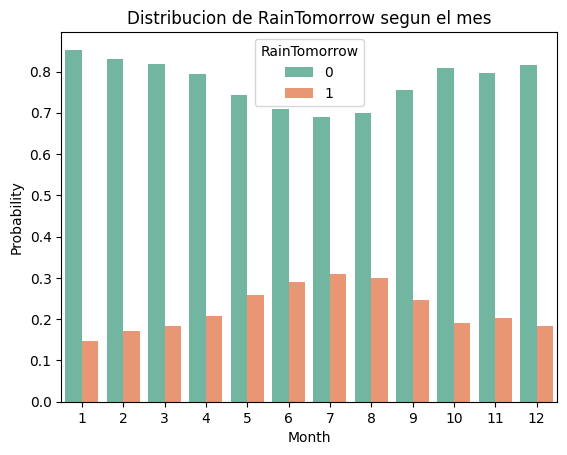

In [387]:
probs = df_train[["Month", "RainTomorrow"]].groupby("Month").value_counts(normalize=True).reset_index(name="Probability")
display(probs.groupby('RainTomorrow')['Probability'].std().reset_index(name='Standard Deviation'))
sns.barplot(x="Month", y="Probability", data=probs, hue="RainTomorrow", palette="Set2")
plt.title("Distribucion de RainTomorrow segun el mes")


,RainTomorrow,Standard Deviation
0,0,0.014004
1,1,0.014004


Text(0.5, 1.0, 'Distribucion de RainTomorrow segun el año')

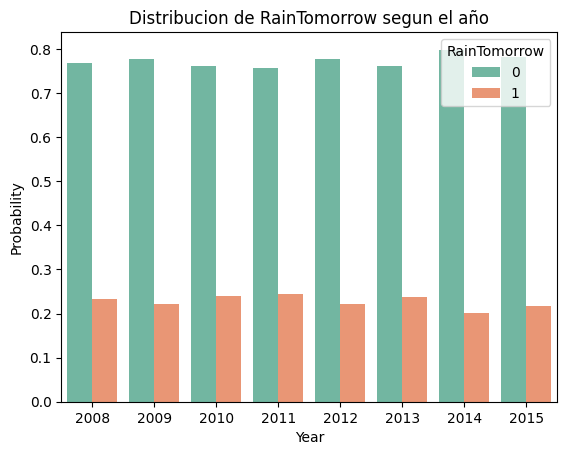

In [388]:
probs = df_train[["Year", "RainTomorrow"]].groupby("Year").value_counts(normalize=True).reset_index(name="Probability")
display(probs.groupby('RainTomorrow')['Probability'].std().reset_index(name='Standard Deviation'))
sns.barplot(x="Year", y="Probability", data=probs, hue="RainTomorrow", palette="Set2")
plt.title("Distribucion de RainTomorrow segun el año")

,RainTomorrow,Standard Deviation
0,0,0.015228
1,1,0.015228


Text(0.5, 1.0, 'Distribucion de RainTomorrow segun el dia')

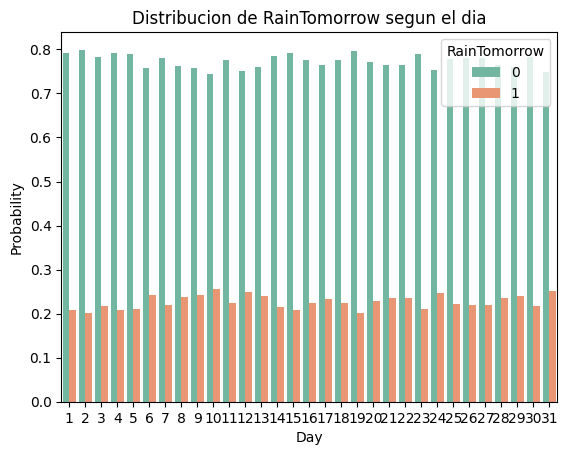

In [389]:
probs = df_train[["Day", "RainTomorrow"]].groupby("Day").value_counts(normalize=True).reset_index(name="Probability")
display(probs.groupby('RainTomorrow')['Probability'].std().reset_index(name='Standard Deviation'))
sns.barplot(x="Day", y="Probability", data=probs, hue="RainTomorrow", palette="Set2")
plt.title("Distribucion de RainTomorrow segun el dia")

,RainTomorrow,Standard Deviation
0,0,0.056165
1,1,0.056165


Text(0.5, 1.0, 'Distribucion de RainTomorrow segun la estacion')

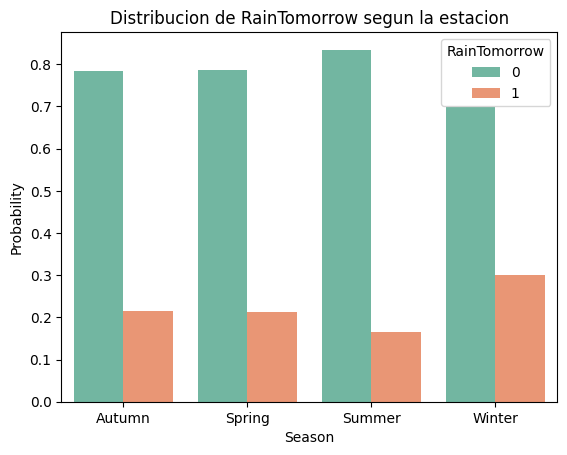

In [390]:
probs = df_train[["Season", "RainTomorrow"]].groupby("Season").value_counts(normalize=True).reset_index(name="Probability")
display(probs.groupby('RainTomorrow')['Probability'].std().reset_index(name='Standard Deviation'))
sns.barplot(x="Season", y="Probability", data=probs, hue="RainTomorrow", palette="Set2")
plt.title("Distribucion de RainTomorrow segun la estacion")

Codifico como funcion periodica al dia del año

In [391]:
df_train['day_sin'] = np.sin(2 * np.pi * df_train['Date'].dt.day_of_year/365)
df_train['day_cos'] = np.cos(2 * np.pi * df_train['Date'].dt.day_of_year/365)

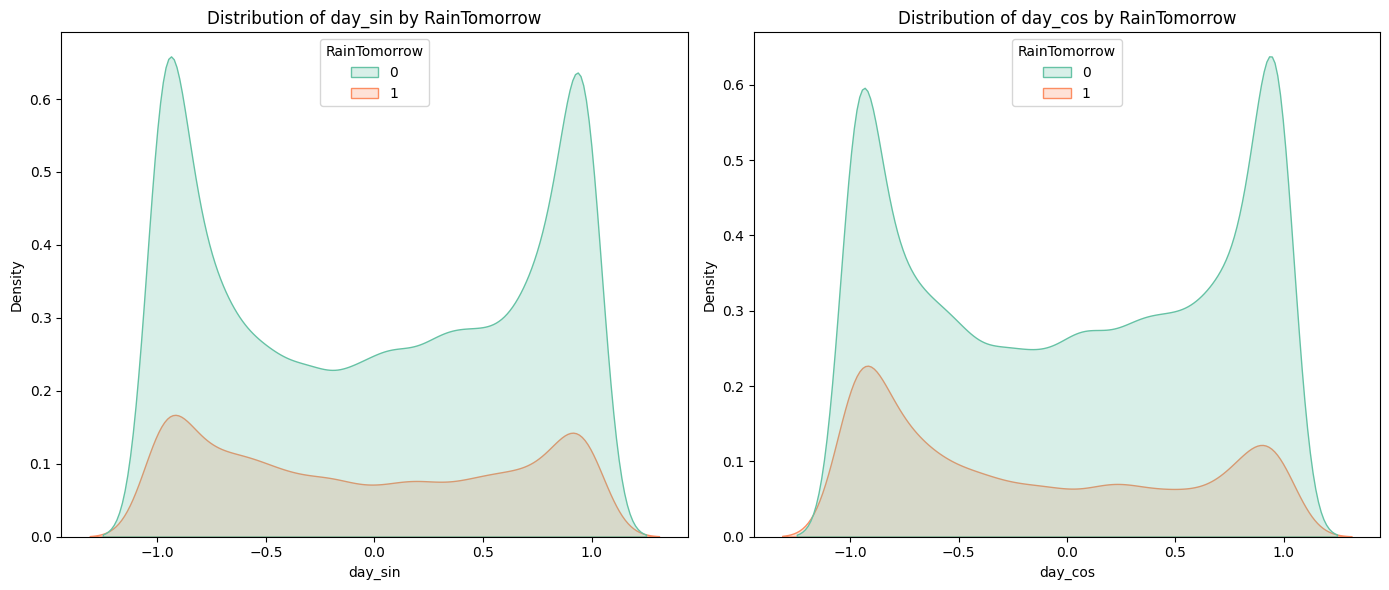

In [392]:
import seaborn as sns
import matplotlib.pyplot as plt

fig, axs = plt.subplots(1, 2, figsize=(14, 6))

# Plot for day_sin
sns.kdeplot(data=df_train, x='day_sin', hue='RainTomorrow', palette='Set2', ax=axs[0], fill=True)
axs[0].set_title('Distribution of day_sin by RainTomorrow')

# Plot for day_cos
sns.kdeplot(data=df_train, x='day_cos', hue='RainTomorrow', palette='Set2', ax=axs[1], fill=True)
axs[1].set_title('Distribution of day_cos by RainTomorrow')

plt.tight_layout()
plt.show()

Basandome en los graficos, la distibucion de sd y resultados de pruebas anteriores en modelos DecisionTree, quedarme con las features dia y cos/sin del dia del año

In [393]:
df_train.drop(columns=["Season", "Year", "Month"], inplace=True)

In [394]:
df_test['Date'].dt.day
df_test['Day'] = df_test['Date'].dt.day
df_test['day_sin'] = np.sin(2 * np.pi * df_test['Date'].dt.day_of_year/365)
df_test['day_cos'] = np.cos(2 * np.pi * df_test['Date'].dt.day_of_year/365)

In [395]:
df_train.to_parquet('weatherAUS_selectedregions_train_encoded_featureengineering.parquet')
df_test.to_parquet('weatherAUS_selectedregions_test_encoded_featureengineering.parquet')

# Arbol de decision

In [128]:
df_train_decision = pd.read_parquet('weatherAUS_selectedregions_train_encoded_featureengineering.parquet')
df_test_decision = pd.read_parquet('weatherAUS_selectedregions_test_encoded_featureengineering.parquet')

## Eliminacion de features no relevantes

Uso un modelo rapido para descartar features basandome en su feature importance

In [251]:
df_train_decision = df_train_decision.sort_values('Date')

X = df_train_decision.drop(columns=['RainTomorrow', 'Date'])
y = df_train_decision['RainTomorrow']
X.RainToday = X.RainToday.astype(int)

model = DecisionTreeClassifier(random_state=42, class_weight="balanced")

tscv = TimeSeriesSplit(n_splits=3)

for train_index, test_index in tscv.split(X):
    X_train, X_test = X.iloc[train_index], X.iloc[test_index]
    y_train, y_test = y.iloc[train_index], y.iloc[test_index]

    smote = SMOTE(sampling_strategy='auto', random_state=42)
    X_resampled, y_resampled = smote.fit_resample(X_train, y_train)

    model.fit(X_resampled, y_resampled)

In [130]:
sorted(list(zip(X.columns.to_list(), model.feature_importances_)), key=lambda x: -x[1])

[('Cloud3pmRainfallRatio', np.float64(0.2485228151799433)),
 ('Humidity3pm', np.float64(0.10122019825112531)),
 ('Pressure3pm', np.float64(0.09104101825762302)),
 ('PressureSunshineRatio', np.float64(0.06611001605056886)),
 ('Rainfall', np.float64(0.05215999567555019)),
 ('WindGustSpeed', np.float64(0.03995420968046615)),
 ('Cloud3pm', np.float64(0.033837594689937106)),
 ('day_sin', np.float64(0.02376311885752052)),
 ('day_cos', np.float64(0.021957144948668874)),
 ('PressureDiff', np.float64(0.021349129370374125)),
 ('HumidityDiff', np.float64(0.017848900418263935)),
 ('HumidityTemp', np.float64(0.016909585277872768)),
 ('Evaporation', np.float64(0.016007677724303632)),
 ('MinTemp', np.float64(0.015822637275918552)),
 ('Day', np.float64(0.015774579261165045)),
 ('WindSpeed9am', np.float64(0.015396239416191409)),
 ('TempDiff', np.float64(0.01515355087118851)),
 ('PressureTemp', np.float64(0.014267972595794053)),
 ('Humidity9am', np.float64(0.013738919919605476)),
 ('Sunshine', np.float6

Elimino las features con importancia <0.5%

In [131]:
feature_importances = model.feature_importances_
threshold = 0.005
feature_names = X.columns

features_to_keep = feature_names[feature_importances > threshold]

df_train_decision = df_train_decision[features_to_keep.to_list() + ["RainTomorrow", "Date"]]

##  Dataframe final
Guardo el dataset final para el DecisionTree


In [132]:
df_train_decision.to_parquet('weatherAUS_selectedregions_train_decisiontree.parquet')
df_test_decision.to_parquet('weatherAUS_selectedregions_test_decisiontree.parquet')

## RandomGrid K-fold CrossValidation

Se utilizaron 3 folds.
Para optimizar los parametros, se considero la metrica f1-score. Se eligio esa metrica teniendo en cuenta el desbalanceo en la variable Raintomorrow y la necesidad de lograr un balance entre falsos positivos y falsos negativos

In [407]:
df_train_decision = pd.read_parquet('weatherAUS_selectedregions_train_decisiontree.parquet')
df_test_decision = pd.read_parquet('weatherAUS_selectedregions_test_decisiontree.parquet')

In [253]:
X = df_train_decision.drop(columns=['RainTomorrow', 'Date'])
y = df_train_decision['RainTomorrow']
X.RainToday = X.RainToday.astype(int)

model = DecisionTreeClassifier(random_state=42)
tscv = TimeSeriesSplit(n_splits=5)
smote = SMOTE(sampling_strategy='auto', random_state=42)

pipeline = Pipeline([
    ('smote', smote),
    ('model', model)
])

param_grid = {
    'model__max_depth': [10, 15, None],
    'model__min_samples_split': [2, 5, 10, 20],
    'model__min_samples_leaf': [1, 2, 4, 8, 16],
    'model__criterion': ['gini', 'entropy'],
    'model__class_weight': [{0: 1, 1:2}, {0: 1, 1:0.5},{0: 1, 1:5},'balanced', None],
}

scorer = make_scorer(f1_score)

grid_search = RandomizedSearchCV(pipeline, scoring = scorer, n_iter=75, param_distributions=param_grid, cv=tscv, n_jobs=-1)

grid_search.fit(X, y)

print(f"Best Parameters: {grid_search.best_params_}")
print(f"Best Cross-Validation Score: {grid_search.best_score_}")

Best Parameters: {'model__min_samples_split': 20, 'model__min_samples_leaf': 2, 'model__max_depth': 10, 'model__criterion': 'gini', 'model__class_weight': None}
Best Cross-Validation Score: 0.6005029507072355


In [254]:
results = pd.DataFrame(grid_search.cv_results_)
results.to_csv('decisiontree_tuning_results.csv', index=False)

Training Set Metrics:
Accuracy: 0.8709
Precision: 0.7805
Recall: 0.5973
F1-Score: 0.6767


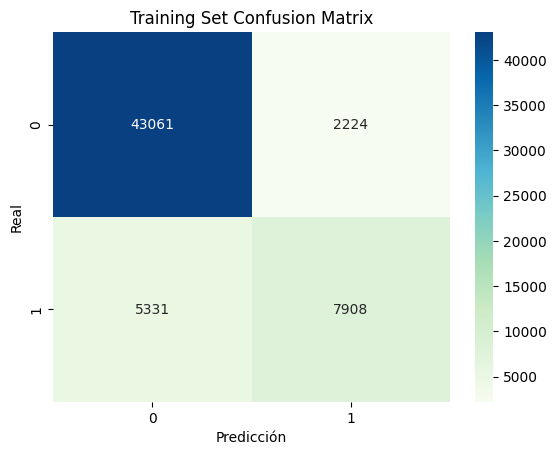

In [415]:
best_model = grid_search.best_estimator_
best_model.fit(X, y)

y_pred = best_model.predict(X)

print("Training Set Metrics:")
print(f"Accuracy: {accuracy_score(y, y_pred):.4f}")
print(f"Precision: {precision_score(y, y_pred):.4f}")
print(f"Recall: {recall_score(y, y_pred):.4f}")
print(f"F1-Score: {f1_score(y, y_pred):.4f}")

# Confusion matrix for training set
train_conf_matrix = confusion_matrix(y, y_pred)
sns.heatmap(train_conf_matrix, cmap='GnBu', annot=True, fmt='g')
plt.title('Training Set Confusion Matrix')
plt.xlabel('Predicción')
plt.ylabel('Real')
plt.show()

In [418]:
with open('decisiontree_model.pkl', 'wb') as f:
    pickle.dump(best_model.named_steps['model'], f)

## Evaluo en test

In [413]:
with open('decisiontree_model.pkl', 'rb') as f:
    best_model = pickle.load(f)

Se obtuvieron los siguientes valores para las metricas:
* Accuracy = 0.8373. (De todas las predicciones hechas, un 0.8373 fueron correctas)
* Precision = 0.6614 (De todas las predicciones positivas (lluvia mañana), un 0.6614 fueron correctas)
* Recall = 0.5363 (De todos los registros positivos (lluvia mañana), un 0.65363597 fue predicho.
* F1-score = 0.5923 (Es una medida combinada de la precision y el recall)
* ROC AUC = 0.8326 (Medida de que tan bueno es el modelo distinguiendo las clases, a partir del ratio VP/FP a medida que se cambia el threshold)

El bajo valor de Recall pareceria indicar que el modelo esta prediciendo que no llovera con menos frequencia de que lo que deberia. (alto numero de FN).

En comparacion, en entrnamiento se obtuvo un f0.60 en el fold con el mejor score y f1-score 0.68 al entrenar con el set de train entero. En el set de test se obtuvo 0.62. Esto pareceria indicar que no hubo over-fitting a los datos de entranamiento


In [272]:
X_test = df_test_decision[best_model.feature_names_in_]
y_test = df_test_decision['RainTomorrow']
y_pred = best_model.predict(X_test)

accuracy = accuracy_score(y_test, y_pred)
precision = precision_score(y_test, y_pred)
recall = recall_score(y_test, y_pred)
f1 = f1_score(y_test, y_pred)

print(f"Test Accuracy: {accuracy:.4f}")
print(f"Test Precision: {precision:.4f}")
print(f"Test Recall: {recall:.4f}")
print(f"Test F1-score: {f1:.4f}")

y_pred_proba = best_model.predict_proba(X_test)[:, 1]
roc_auc = roc_auc_score(y_test, y_pred_proba)
print(f"Test ROC AUC: {roc_auc:.4f}")

Test Accuracy: 0.8373
Test Precision: 0.6614
Test Recall: 0.5363
Test F1-score: 0.5923
Test ROC AUC: 0.8394


Se observa en la matriz de confusion que el numero de falsos y verdaderos positivos es similar, es decir que cuando el modelo predice lluvia se equivoca practicamente la mitad de las veces (Otra manera de ver la precision)

La performance al identificar Raintomorrow = 0 es mejor, pero esto se esperaba debido al desbalanceo propio del target,

Text(50.722222222222214, 0.5, 'Real')

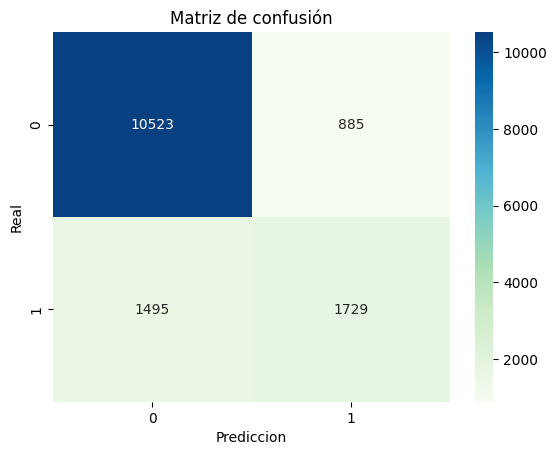

In [270]:
tabla=confusion_matrix(y_test, y_pred)

#Grafico la matriz de confusión
sns.heatmap(tabla,cmap='GnBu',annot=True,fmt='g')
plt.title('Matriz de confusión')
plt.xlabel('Prediccion')
plt.ylabel('Real')

## Grafico del arbol obtenido

La primera regla evaluada por el modelo es Humidity3pm ≤ 66.5%. Las ramas izquierdas (cumplen la condición) tienen mayor proporción de No Rain que las derechas.

En la rama izquierda del primer nodo, el siguiente criterio es Sunshine ≤ 7.7 hs. Independientemente del resultado de esto, los nodos hijos deciden según Pressure3pm ≤ 1013.15 hPa.  A partir de ahí, los hijos del nodo izquierdo deciden en base a WindGustSpeed < X, y los del derecho a partir de Sunshine. Estas decisiones se corresponden con las esperadas: Baja humedad, cielo despejado y presión baja  son indicadores comunes de ausencia de lluvia. En cuanto al viento, vientos fuertes podrían traer frentes secos en las regiones específicas analizadas.

Por otro lado, en la rama derecha del nodo raíz (Humidity3pm > 66.5%), el modelo evalúa vuelve a decidir en base a la misma variable (Humidity3pm ≤ 82.5%). Si la humedad es menor a 82.5%, el modelo continúa con WindGustSpeed ≤ 42.41 km/h. En la rama izquierda a esa se decide en base a Pressure3pm (≤ 1018.95 hPa). En la derecha se utiliza el producto de dos variables: Cloud3pmRainfallRatio ≤ 1.7 octas*mm. En la rama donde Humidity3pm > 82.5%, se vuelve a utilizar Pressure3pm ≤ 1015.05 hPa. A partir de ahí se utiliza el índice PressureSunshineRatio ≤ 155.422 hPa/hs a la izquierda y Rainfall a la derecha.

En síntesis se observa un alto poder discriminatorio para las variables Humidity3pm, Sunshine, Pressure3pm, WindGustSpeed y Rainfall y sus derivados



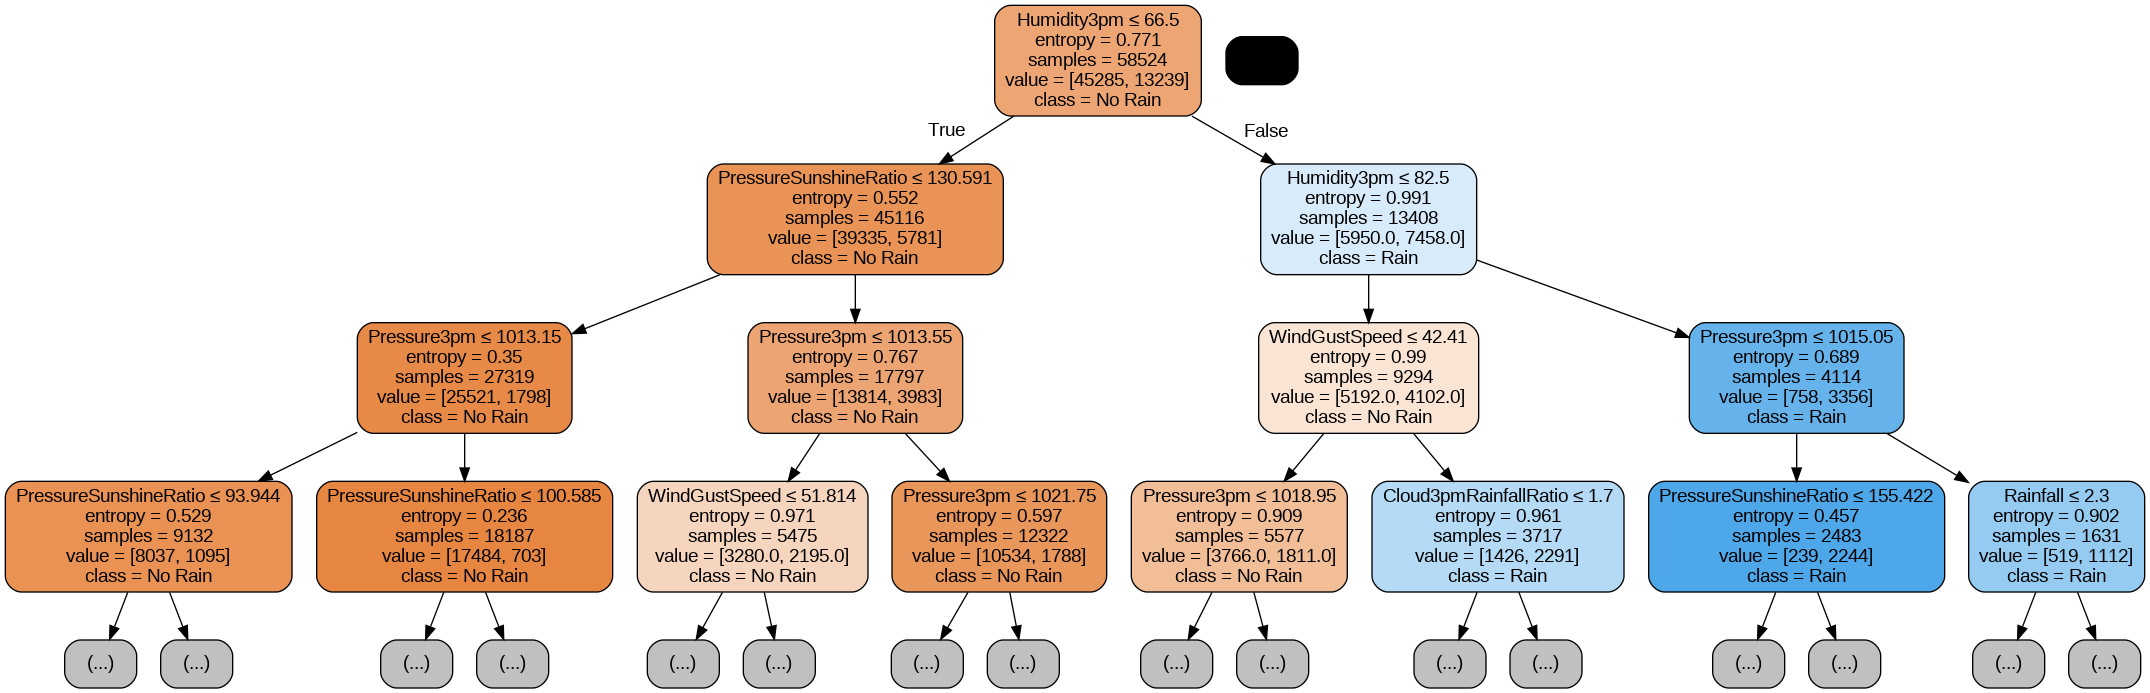

In [416]:
dot_data = StringIO()
export_graphviz(best_model, out_file=dot_data,
                max_depth=3,
                filled=True, rounded=True,
                special_characters=True,
                feature_names=best_model.feature_names_in_,
                class_names=['No Rain','Rain'])

graph = pydotplus.graph_from_dot_data(dot_data.getvalue())
Image(graph.create_png())


# Random Forest

In [ ]:
df_train_forest = pd.read_parquet('weatherAUS_selectedregions_train_encoded_featureengineering.parquet')
df_test_forest = pd.read_parquet('weatherAUS_selectedregions_test_encoded_featureengineering.parquet')

## Eliminacion de features no relevantes

Uso un modelo rapido para descartar features basandome en su feature importance

In [ ]:
df_train_forest = df_train_forest.sort_values('Date')
df_train_forest.RainToday = df_train_forest.RainToday.astype(int)


X = df_train_forest.drop(columns=['RainTomorrow', 'Date'])
y = df_train_forest['RainTomorrow']

model = RandomForestClassifier(random_state=42, class_weight="balanced")

tscv = TimeSeriesSplit(n_splits=3)

scores = []

for train_index, test_index in tscv.split(X):
    X_train, X_test = X.iloc[train_index], X.iloc[test_index]
    y_train, y_test = y.iloc[train_index], y.iloc[test_index]

    smote = SMOTE(sampling_strategy='auto', random_state=42)
    X_resampled, y_resampled = smote.fit_resample(X_train, y_train)

    model.fit(X_resampled, y_resampled)

    y_pred = model.predict(X_test)

    accuracy = f1_score(y_test, y_pred)
    scores.append(accuracy)

In [ ]:
sorted(list(zip(X.columns.to_list(), model.feature_importances_)), key=lambda x: -x[1])

[('Humidity3pm', np.float64(0.0887649803066332)),
 ('Rainfall', np.float64(0.06732286035832909)),
 ('Cloud3pmRainfallRatio', np.float64(0.06467733853238182)),
 ('PressureSunshineRatio', np.float64(0.06415058954031906)),
 ('Pressure3pm', np.float64(0.06173303854577028)),
 ('Sunshine', np.float64(0.0591028128487897)),
 ('TempDiff', np.float64(0.04627059151891829)),
 ('Cloud3pm', np.float64(0.04347107531362626)),
 ('WindGustSpeed', np.float64(0.040126693030638455)),
 ('HumidityDiff', np.float64(0.03468903374418916)),
 ('Humidity9am', np.float64(0.03008134321405857)),
 ('Cloud9am', np.float64(0.029574556664831147)),
 ('HumidityTemp', np.float64(0.027902717586166553)),
 ('PressureTemp', np.float64(0.02523856213602407)),
 ('day_sin', np.float64(0.023892881629951013)),
 ('day_cos', np.float64(0.023315205461914894)),
 ('Temp3pm', np.float64(0.022515473111442776)),
 ('PressureDiff', np.float64(0.02236998576981008)),
 ('MinTemp', np.float64(0.019760509703819793)),
 ('WindSpeed3pm', np.float64(0.

Elimino las features con importancia <0.5%

In [ ]:
feature_importances = model.feature_importances_
threshold = 0.005
feature_names = X.columns

features_to_keep = feature_names[feature_importances > threshold]

df_train_forest = df_train_forest[features_to_keep.to_list() + ["RainTomorrow", "Date"]]

##  Dataframe final
Guardo el dataset final para el RandomForest


In [180]:
df_train_forest.to_parquet('weatherAUS_selectedregions_train_randomforest.parquet')
df_test_forest.to_parquet('weatherAUS_selectedregions_test_randomforest.parquet')

## RandomGrid K-fold CrossValidation

Se utilizaron 3 folds.
Para optimizar los parametros, se considero la metrica f1-score. Se eligio esa metrica teniendo en cuenta el desbalanceo en la variable Raintomorrow y la necesidad de lograr un balance entre falsos positivos y falsos negativos

In [274]:
df_train_forest = pd.read_parquet('weatherAUS_selectedregions_train_randomforest.parquet')
df_test_forest = pd.read_parquet('weatherAUS_selectedregions_test_randomforest.parquet')
X = df_train_forest.drop(columns=['RainTomorrow', 'Date'])
y = df_train_forest['RainTomorrow']

In [275]:
model = RandomForestClassifier(random_state=42)
tscv = TimeSeriesSplit(n_splits=5)
smote = SMOTE(sampling_strategy='auto', random_state=42)

pipeline = Pipeline([
    ('smote', smote),
    ('model', model)
])

param_grid = {
    "model__criterion" : ["gini", "entropy"],
    "model__max_features": [None, "sqrt", "log2"],
    "model__n_estimators": [5, 10, 20, 30],
    'model__max_depth': [1,5, 10, None],
    'model__min_samples_split': [2, 4, 5],
    'model__min_samples_leaf': [1,2, 4],
    'model__criterion': ['gini', 'entropy'],
    'model__class_weight': [{0: 1, 1:5}, {1:1, 1:10}],
}

scorer = make_scorer(precision_score)

grid_search = RandomizedSearchCV(pipeline, scoring = scorer, n_iter=30, param_distributions=param_grid, cv=tscv, n_jobs=-1)

grid_search.fit(X, y)

print(f"Best Parameters: {grid_search.best_params_}")
print(f"Best Cross-Validation Score: {grid_search.best_score_}")

Best Parameters: {'model__n_estimators': 10, 'model__min_samples_split': 2, 'model__min_samples_leaf': 2, 'model__max_features': None, 'model__max_depth': None, 'model__criterion': 'entropy', 'model__class_weight': {1: 10}}
Best Cross-Validation Score: 0.6300818252642038


In [276]:
results = pd.DataFrame(grid_search.cv_results_)
results.to_csv('randomforest_tuning_results.csv', index=False)

Training Set Metrics:
Accuracy: 0.9849
Precision: 0.9600
Recall: 0.9736
F1-Score: 0.9668


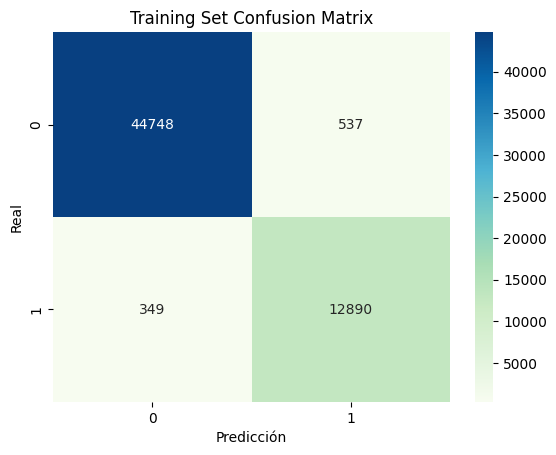

In [291]:
best_model = grid_search.best_estimator_

best_model.fit(X, y)

y_pred = best_model.predict(X)

print("Training Set Metrics:")
print(f"Accuracy: {accuracy_score(y, y_pred):.4f}")
print(f"Precision: {precision_score(y, y_pred):.4f}")
print(f"Recall: {recall_score(y, y_pred):.4f}")
print(f"F1-Score: {f1_score(y, y_pred):.4f}")

# Confusion matrix for training set
train_conf_matrix = confusion_matrix(y, y_pred)
sns.heatmap(train_conf_matrix, cmap='GnBu', annot=True, fmt='g')
plt.title('Training Set Confusion Matrix')
plt.xlabel('Predicción')
plt.ylabel('Real')
plt.show()

In [294]:
with open('randomforest_model.pkl', 'wb') as f:
    pickle.dump(best_model.named_steps['model'], f)

## Feature Importance

In [402]:
with open('randomforest_model.pkl', 'rb') as f:
    best_model = pickle.load(f)

A partir del analisis de Feature Importance, se observa que el modelo para depender fuertemente en Clod3pmRainfallRatio. Analizando varios de los arboles se observa que el modelo esta usando Cloud3pmRainfallRatio como un sustituto de raintoday = 1 o rainfall = 0 (ya que la mayoria de estos estan haciendo la primer separacion en base a Cloud3pmRainfallRatio < 0, lo cual se que practicamente solo se cumple si rainfall = 0)

Ademas de esa variable, el modelo mayoritariamente parece apoyarse en Pressure3pm, Humidity3pm, PressureSunshineRatio y WindSpeed3pm. Estas variables suelen ser consideradas buenas predictoras de lluvia.  

Luego el modelo utiliza el resto de las variables numericas, mientras que las direcciones de viento parecen tener la menor importancia. Esto es parcialmente esperable debido a que cada variable categorica encodeada por OHE tiene por si sola poco poder discriminatorio

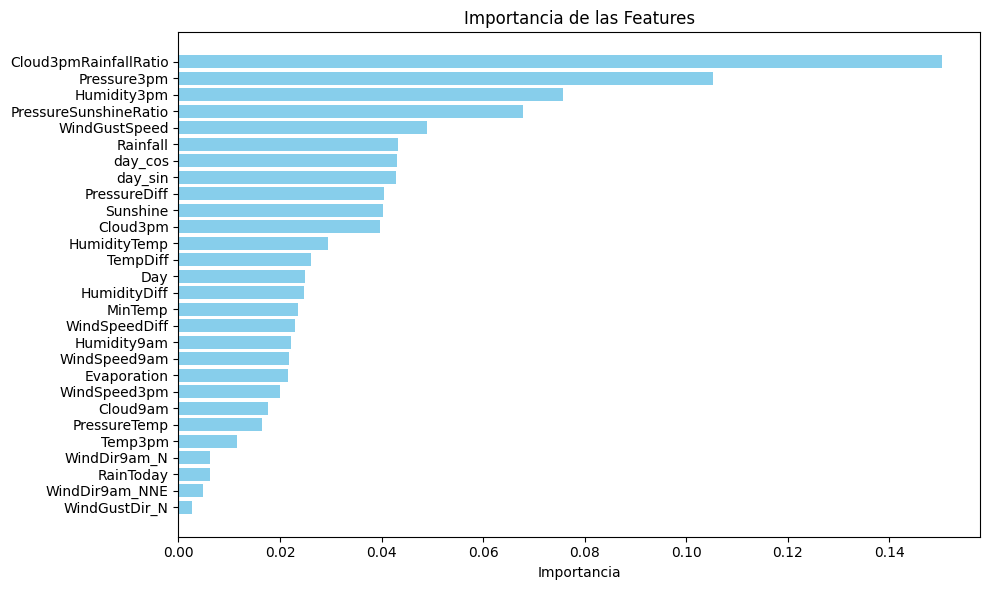

In [298]:
feature_importances = best_model.feature_importances_

importances_df = pd.DataFrame({
    'Feature': X.columns,
    'Importance': feature_importances
}).sort_values(by='Importance', ascending=False)

# Graficar
plt.figure(figsize=(10, 6))
plt.barh(importances_df['Feature'], importances_df['Importance'], color='skyblue')
plt.gca().invert_yaxis()
plt.xlabel('Importancia')
plt.title('Importancia de las Features')
plt.tight_layout()
plt.show()


## Evaluo en test

Se obtuvieron los siguientes valores para las metricas:
* Accuracy = 0.8371. (De todas las predicciones hechas, un 0.8371 fueron correctas)
* Precision = 0.6371 (De todas las predicciones positivas (lluvia mañana), un 0.6371 fueron correctas)
* Recall = 0.6055 (De todos los registros positivos (lluvia mañana), un 0.6055 fue predicho.
* F1-score = 0.6209 (Es una medida combinada de la precision y el recall)
* ROC AUC = 0.8536 (Medida de que tan bueno es el modelo distinguiendo las clases, a partir del ratio VP/FP a medida que se cambia el threshold)

En comparacion al Decision Tree, este modelo logra mejorar el recall sin comprometer la precision, lo que se traduce en un f1-score ligeramente mas alto.

En comparacion, en entrnamiento se obtuvo un f1-score: 0.63 en el fold con el mejor score y f1-score 0.97 al entrenar con el set de train entero. En el set de test se obtuvo 0.62. Esto pareceria indicar overfitting del modelo a los datos de entrenamiento


In [299]:
X_test = df_test_forest[best_model.feature_names_in_]
y_test = df_test_forest['RainTomorrow']
y_pred = best_model.predict(X_test)

accuracy = accuracy_score(y_test, y_pred)
precision = precision_score(y_test, y_pred)
recall = recall_score(y_test, y_pred)
f1 = f1_score(y_test, y_pred)

print(f"Test Accuracy: {accuracy:.4f}")
print(f"Test Precision: {precision:.4f}")
print(f"Test Recall: {recall:.4f}")
print(f"Test F1-score: {f1:.4f}")

y_pred_proba = best_model.predict_proba(X_test)[:, 1]
roc_auc = roc_auc_score(y_test, y_pred_proba)
print(f"Test ROC AUC: {roc_auc:.4f}")

Test Accuracy: 0.8371
Test Precision: 0.6371
Test Recall: 0.6055
Test F1-score: 0.6209
Test ROC AUC: 0.8536


Text(50.722222222222214, 0.5, 'Real')

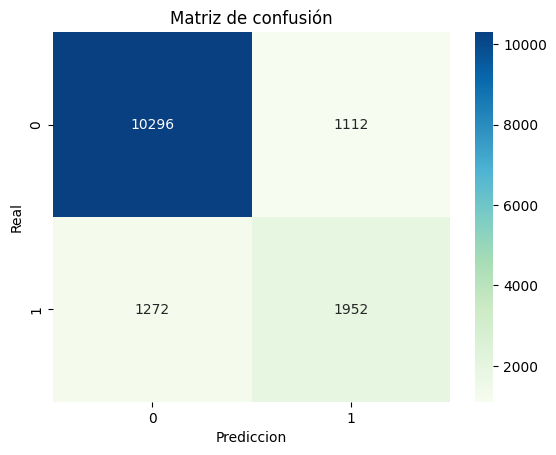

In [300]:
tabla=confusion_matrix(y_test, y_pred)

#Grafico la matriz de confusión
sns.heatmap(tabla,cmap='GnBu',annot=True,fmt='g')
plt.title('Matriz de confusión')
plt.xlabel('Prediccion')
plt.ylabel('Real')

## Grafico del arbol obtenido

La primera regla en ser evaluada es Cloud3pmRainfallRatio <= 0 octas * mm. Como el producto no puede ser negativo, y Cloud3pm es rara vez cero, por lo que el modelo básicamente se está preguntando si llovió o no ese dia (Rainfall = 0)

En la rama de la izquierda (Cloud3pmRainfallRatio <= 0, mayor proporción de no lluvia que en la rama derecha) la siguiente decisión es PressureSunshineRatio < 12 hPa/hs.

Si se cumple la condición, se decide en base a Cloud3pm <= 1 octas y luego en base a PressionDiff < -5 hPa a la izquierda y Pressure3pm < 1015 a la derecha. Si no se cumple, se decide en base a Pressure3pm < 1018 y luego en base a Cloud3pm 4<5.4 a la izquierda y Humidity3pm a la derecha. En resumen, baja nubosidad, presión baja o disminuyendo, y poca humedad parecen ser determinantes de que no llueva mañana.

En cuanto a la rama  derecha del nodo raíz, el modelo decide en base a Humidity 3pm < 66%. Sea cual sea ese valor, se vuelve a separar en base a Pressure3pm < 1020hPa. En los cuatro nodos hijos de esos dos se decide en base a PressureSunshineRatio, Humidity3pm y HumidityDiff.
Se observa que las mismas variables tienden a aparecer varias veces y con el mismo criterio.


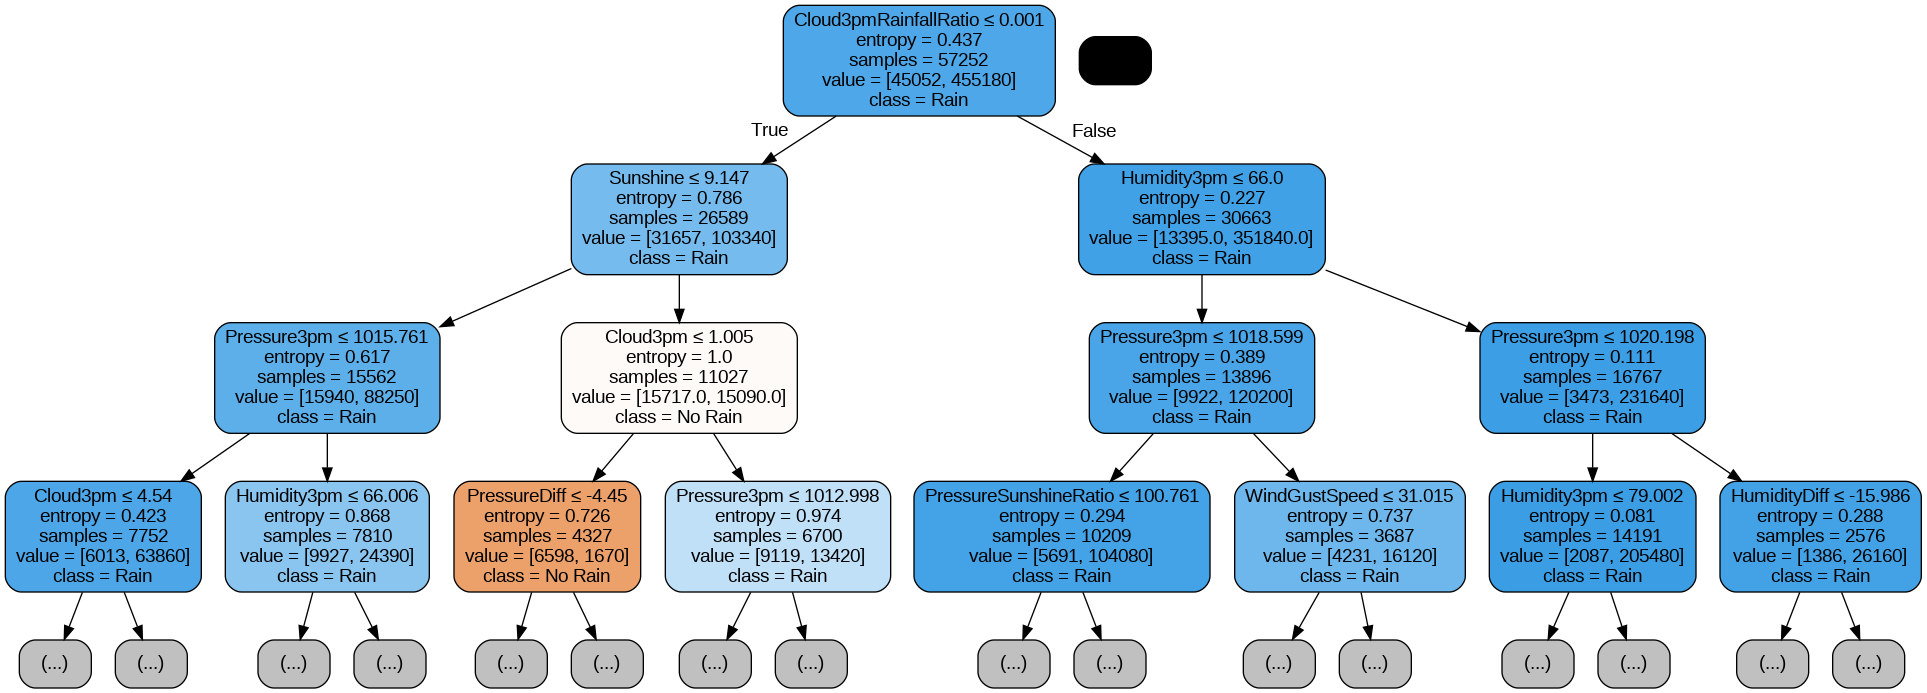

In [323]:
dot_data = StringIO()
export_graphviz(best_model.estimators_[0], out_file=dot_data,
                max_depth=3,
                filled=True, rounded=True,
                special_characters=True,
                feature_names=best_model.feature_names_in_,
                class_names=['No Rain','Rain'])

graph = pydotplus.graph_from_dot_data(dot_data.getvalue())
Image(graph.create_png())


# Boosting Classifier

In [85]:
df_train_boosting = pd.read_parquet('weatherAUS_selectedregions_train_encoded_featureengineering.parquet')
df_test_boosting = pd.read_parquet('weatherAUS_selectedregions_test_encoded_featureengineering.parquet')

## Eliminacion de features no relevantes

Uso un modelo rapido para descartar features basandome en su feature importance

In [ ]:
from sklearn.inspection import permutation_importance

df_train_boosting = df_train_boosting.sort_values('Date')
df_train_boosting.RainToday = df_train_boosting.RainToday.astype(int)

X = df_train_boosting.drop(columns=['RainTomorrow', 'Date'])
y = df_train_boosting['RainTomorrow']

model = HistGradientBoostingClassifier(random_state=42)

tscv = TimeSeriesSplit(n_splits=3)

all_importances = []

for train_index, test_index in tscv.split(X):
    X_train, X_test = X.iloc[train_index], X.iloc[test_index]
    y_train, y_test = y.iloc[train_index], y.iloc[test_index]

    smote = SMOTE(sampling_strategy='auto', random_state=42)
    X_resampled, y_resampled = smote.fit_resample(X_train, y_train)

    model.fit(X_resampled, y_resampled)

    result = permutation_importance(
        model, X_test, y_test,
        n_repeats=10, random_state=42, n_jobs=-1
    )

    # Save importances for this fold
    all_importances.append(result.importances_mean)

In [ ]:
importances_array = np.vstack(all_importances)  # shape (n_folds, n_features)
mean_importances = np.mean(importances_array, axis=0)

# Show final sorted feature importance
feature_names = X.columns  # assuming DataFrame
sorted_idx = np.argsort(mean_importances)

importances_df = pd.DataFrame({
    'Feature': feature_names,
    'Importance': mean_importances
})

importances_df = importances_df.sort_values(by='Importance', ascending=False)
importances_df.to_csv('boosting_feature_importances.csv', index=False)

Elimino las features con importancia <0.5%

In [ ]:
importances_df = pd.read_csv('boosting_feature_importances.csv')

threshold = 0.005
feature_names = X.columns


features_to_keep = importances_df[importances_df["Importance"] > threshold].Feature.to_list()
df_train_boosting = df_train_boosting[features_to_keep + ["RainTomorrow", "Date"]]
df_test_boosting = df_test_boosting[features_to_keep + ["RainTomorrow", "Date"]]


##  Dataframe final
Guardo el dataset final para el DecisionTree


In [91]:
df_train_boosting.to_parquet('weatherAUS_selectedregions_train_boostingtree.parquet')
df_test_boosting.to_parquet('weatherAUS_selectedregions_test_boostingtree.parquet')

## RandomGrid K-fold CrossValidation

In [302]:
df_train_boosting = pd.read_parquet('weatherAUS_selectedregions_train_boostingtree.parquet')
df_test_boosting = pd.read_parquet('weatherAUS_selectedregions_test_boostingtree.parquet')
X = df_train_boosting.drop(columns=['RainTomorrow', 'Date'])
X.RainToday = X.RainToday.astype(int)

y = df_train_boosting['RainTomorrow']

In [303]:
model = HistGradientBoostingClassifier(random_state=42)
tscv = TimeSeriesSplit(n_splits=5)
smote = SMOTE(sampling_strategy='auto', random_state=42)

pipeline = Pipeline([
    ('smote', smote),
    ('model', model)
])

param_grid = {
    'model__learning_rate': [0.05, 0.1, 0.2],
    'model__max_iter': [100, 300, 500],
    'model__max_leaf_nodes': [5, 10, 15, 31],
    'model__max_depth': [5, 7, 9],
    'model__min_samples_leaf': [5, 10, 20],
    'model__l2_regularization': [0.0, 10.0, 100.0],
    'model__max_bins': [50, 100],
}

scorer = make_scorer(f1_score)

grid_search = RandomizedSearchCV(pipeline, scoring = scorer, n_iter=30, param_distributions=param_grid, cv=tscv, n_jobs=-1)

grid_search.fit(X, y)

print(f"Best Parameters: {grid_search.best_params_}")
print(f"Best Cross-Validation Score: {grid_search.best_score_}")

Best Parameters: {'model__min_samples_leaf': 5, 'model__max_leaf_nodes': 15, 'model__max_iter': 100, 'model__max_depth': 7, 'model__max_bins': 100, 'model__learning_rate': 0.1, 'model__l2_regularization': 10.0}
Best Cross-Validation Score: 0.6567485999308675


In [304]:
results = pd.DataFrame(grid_search.cv_results_)
results.to_csv('gradientboosting_tuning_results.csv', index=False)

Training Set Metrics:
Accuracy: 0.8470
Precision: 0.6490
Recall: 0.7050
F1-Score: 0.6758


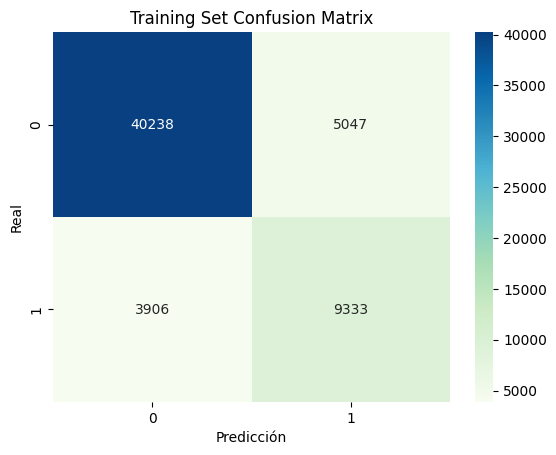

In [309]:
best_model = grid_search.best_estimator_

best_model.fit(X, y)

y_pred = best_model.predict(X)

print("Training Set Metrics:")
print(f"Accuracy: {accuracy_score(y, y_pred):.4f}")
print(f"Precision: {precision_score(y, y_pred):.4f}")
print(f"Recall: {recall_score(y, y_pred):.4f}")
print(f"F1-Score: {f1_score(y, y_pred):.4f}")

# Confusion matrix for training set
train_conf_matrix = confusion_matrix(y, y_pred)
sns.heatmap(train_conf_matrix, cmap='GnBu', annot=True, fmt='g')
plt.title('Training Set Confusion Matrix')
plt.xlabel('Predicción')
plt.ylabel('Real')
plt.show()

In [306]:
with open('gradientboosting_model.pkl', 'wb') as f:
    pickle.dump(best_model.named_steps['model'], f)

## Evaluo en test

In [307]:
with open('gradientboosting_model.pkl', 'rb') as f:
    best_model = pickle.load(f)

Se obtuvieron los siguientes valores para las metricas:
* Accuracy = 0.8353. (De todas las predicciones hechas, un 0.8353 fueron correctas)
* Precision = 0.6142 (De todas las predicciones positivas (lluvia mañana), un 0.6142 fueron correctas)
* Recall = 0.6790 (De todos los registros positivos (lluvia mañana), un 0.6790 fue predicho.
* F1-score = 0.6450 (Es una medida combinada de la precision y el recall)
* ROC AUC = 0.8746 (Medida de que tan bueno es el modelo distinguiendo las clases, a partir del ratio VP/FP a medida que se cambia el threshold)

Este modelo parece estar consiguiendo el mejor balance entre precision y recall de los 3 analizados

En comparacion, en entrenamiento se obtuvo un f1-score: 0.66 en el fold con el mejor score y f1-score 0.68  al entrenar con el set de train entero. En el set de test se obtuvo 0.64.


In [308]:
X_test = df_test_boosting.drop(columns=['RainTomorrow', 'Date'])
y_test = df_test_boosting['RainTomorrow']
y_pred = best_model.predict(X_test)

accuracy = accuracy_score(y_test, y_pred)
precision = precision_score(y_test, y_pred)
recall = recall_score(y_test, y_pred)
f1 = f1_score(y_test, y_pred)

print(f"Test Accuracy: {accuracy:.4f}")
print(f"Test Precision: {precision:.4f}")
print(f"Test Recall: {recall:.4f}")
print(f"Test F1-score: {f1:.4f}")

y_pred_proba = best_model.predict_proba(X_test)[:, 1]
roc_auc = roc_auc_score(y_test, y_pred_proba)
print(f"Test ROC AUC: {roc_auc:.4f}")

Test Accuracy: 0.8353
Test Precision: 0.6142
Test Recall: 0.6790
Test F1-score: 0.6450
Test ROC AUC: 0.8746


Text(50.722222222222214, 0.5, 'Real')

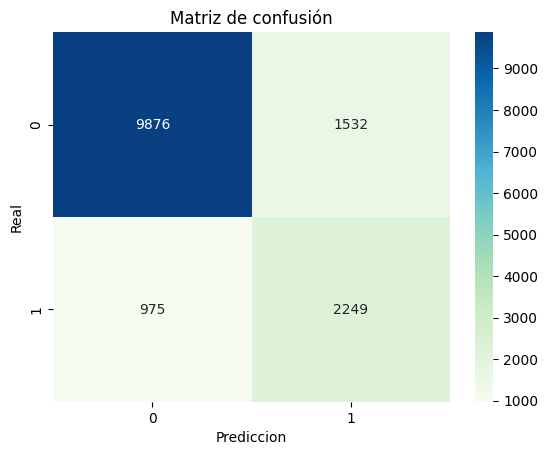

In [105]:
tabla=confusion_matrix(y_test, y_pred)

#Grafico la matriz de confusión
sns.heatmap(tabla,cmap='GnBu',annot=True,fmt='g')
plt.title('Matriz de confusión')
plt.xlabel('Prediccion')
plt.ylabel('Real')